
# Modelos discretos de Depredador-Presa
Por Rodolfo, Carolina y Miguel
Temas Selectos de Física Computacional II
Prof. Luis Benet
Ayudante: Uriel Allan Acevedo


In [76]:
Pkg.add("LsqFit");
Pkg.add("TaylorSeries");
Pkg.update();

INFO: Nothing to be done
INFO: METADATA might be out-of-date — you may not have the latest version of LsqFit
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA might be out-of-date — you may not have the latest version of TaylorSeries
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Updating METADATA...


LoadError: LoadError: METADATA cannot be updated. Resolve problems manually in /home/mrg/.julia/v0.5/METADATA.
GitError(Code:ERROR, Class:Net, Failed to resolve address for github.com: Name or service not known)
 in macro expansion at ./libgit2/error.jl:99 [inlined]
 in #fetch#52(::Base.LibGit2.FetchOptions, ::String, ::Function, ::Base.LibGit2.GitRemote, ::Array{AbstractString,1}) at ./libgit2/remote.jl:70
 in (::Base.LibGit2.#kw##fetch)(::Array{Any,1}, ::Base.LibGit2.#fetch, ::Base.LibGit2.GitRemote, ::Array{AbstractString,1}) at ./<missing>:0
 in #fetch#93(::String, ::String, ::Array{AbstractString,1}, ::Nullable{Base.LibGit2.AbstractCredentials}, ::Function, ::Base.LibGit2.GitRepo) at ./libgit2/libgit2.jl:164
 in (::Base.Pkg.Entry.##35#41)(::Base.LibGit2.GitRepo) at ./pkg/entry.jl:371
 in with(::Base.Pkg.Entry.##35#41, ::Base.LibGit2.GitRepo) at ./libgit2/types.jl:638
 in update(::String, ::Set{String}) at ./pkg/entry.jl:354
 in (::Base.Pkg.Dir.##2#3{Array{Any,1},Base.Pkg.Entry.#update,Tuple{String,Set{String}}})() at ./pkg/dir.jl:31
 in cd(::Base.Pkg.Dir.##2#3{Array{Any,1},Base.Pkg.Entry.#update,Tuple{String,Set{String}}}, ::String) at ./file.jl:59
 in #cd#1(::Array{Any,1}, ::Function, ::Function, ::String, ::Vararg{Any,N}) at ./pkg/dir.jl:31
 in update() at ./pkg/pkg.jl:210
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mrg/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /home/mrg/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[76], in expression starting on line 3

In [77]:
using Plots, LaTeXStrings, TaylorSeries, LsqFit, PyPlot
include("AutomDiff_V2.jl")
import AD: Dual, xdual

Los Modelos de Cazador-Presa son aquellos que representan la interacción de dos especies, una como cazador y otra como presa utilziados principalmente en ecología y biología pero con un sinúmero de aplicaciones en otras áreas de física, química y hasta economía.

En ecología se llaman modelos de "Depredador—presa" o de "planta—hervíboro". En este trabajo se les llama, modelos de "Depredador-Presa".

## Un modelo simple

Siguiendo la línea del libro de  [_Allman & Rhodes_](http://bookzz.org/book/436360/381bdc "Allman, Elizabeth S.; Rhodes, John A. 2003. Mathematical models in biology. An introduction") usaremos un modelo simple en este trabajo:

Se tienen dos especies, una de la cual es presa de la otra. También asumimos que la interacción entre las dos especies es el factor primario para determinar el tamaño de las poblaciones.

Denotamos $P_t$ el tamaño de la población de presas y $Q_t$ el tamaño de la población de de depredadores en un tiempo $t$, el cambio en la población de las dos especies está interrelacionado:

$$
\begin{aligned}
\Delta P &= F(P,Q)\\
\Delta Q &= G(P,Q)
\end{aligned}
$$

Ahora, para definir las funciones $F$ y $G$ de cambio pensemos en el caso en que no hubises predadores, la población de presas crecería hasta un punto en el que no hubiese más lugar o recursos, lo cual es modelado por la función logística:

$$
\Delta P = rP\left( 1-P\right)
$$

En este modelo, $r$ es la tasa de crecimiento de las presas y 1 es su "capacidad de carga", podemos observar que si en algún momento $P>1$, $(1-P)<0$ y así, en el siguiente paso, la población disminuye. 

En cambio, si no hubiera presas los depredadores se morirían, ya que no tendrían fuente de alimentos:

$$
\Delta Q = -u Q
$$

Con $u$ positiva y menor a 1, ya que sólo se pueden morir todos los depredadores, pero no más. (En el caso de $u=1$ la población de depredadores desaparecería.)

Para introducir la interacción mutua entre las dos especies empleamos el producto $PQ$. Dado que la interacción con el depredador disminuye a la problación de presas pero beneficia a la de depredadores, obtenemos las siguientes ecuaciones:

$$
\begin{aligned}
\Delta P &= rP\left( 1-P \right)-sPQ\\
\Delta Q &= -uQ+vPQ
\end{aligned}
$$

Donde $s$ y $v$ son constantes positivas que denontan queé tanto afecta o beneficia la interacción entre ambas especies a las presas o a los depredadores, respectivamente.

Si escribimos el modelo en términos de la población absoluta en lugar de cambios en la población lo que hay que hacer es sumar la población anterior, y obtenemos:


\begin{aligned}
P_{t+1} &= P_t \left( 1+r \left( 1-P_t \right)\right)-s P_t Q_t\\
Q_{t+1} &= (1-u)Q_t+v P_t Q_t
\end{aligned}

Con $r$, $s$, $u$ y $v$ constantes positivas, y $u<1$.

Por lo general estas ecuaciones se estudian en el caso continuo, como ecuaciones diferenciales, pero la dinámica en el caso discreto es distinta. Es importante entender este caso también porque las poblaciones no cambian continuamente, así que un modelo discreto tal vez es más adecuado. 

Observamos que el modelo es un mapeo discreto de dos dimensiones, no-lineal y con múltiples parámetros. Definimos el mapeo:

In [78]:
function LotkaVolterra(X,parametros)
    x=X[1]
    y=X[2]
    a=parametros[1]
    b=parametros[2]
    c=parametros[3]
    d=parametros[4]
    z1=x+a*x*(1-x)-b*x*y
    z2=y-c*y+d*x*y
    return(z1,z2)
end

LotkaVolterra (generic function with 1 method)

In [79]:
parametros=[1.3,0.5,0.7,1.6]
parametros1=[1.3,0.5,0.3,1.6];

In [80]:
function Orbita(x0,parametros,iteraciones)
    X=[]
    Y=[]
    T=[]
    x=x0
    for i in 1:iteraciones
        push!(X,x[1])
        push!(Y,x[2])
        push!(T,i)
        x=LotkaVolterra(x,parametros)
    end
    return[X,Y,T]
end

Orbita (generic function with 1 method)

Para empezar a analizar la dinámica de este modelo, haremos un estudio de caso y analizaremos qué pasa alrededor de los parámetros $(r,s,u,v)=(1,0.5,0.7,1.6)$


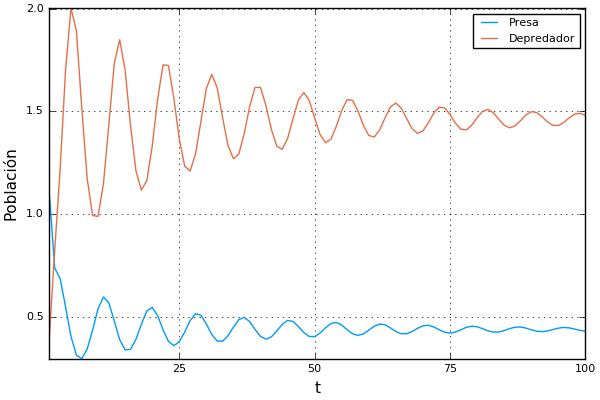

In [81]:
Plots.plot(Orbita([1.10,0.40], parametros, 100)[3],Orbita([1.10,0.40], parametros, 100,)[1],xlabel="t",ylabel="Población",label="Presa")
Plots.plot!(Orbita([1.10,0.40], parametros, 100)[3],Orbita([1.10,0.40], parametros, 100)[2],label="Depredador")



In [82]:
plot(Orbita([1.10,0.40],parametros,100)[1],Orbita([1.10,0.40],parametros,100)[2],xlabel="Presa",ylabel="Depredador",label="x_0=[1.10,0.40]")
plot!(Orbita([0.5,0.40],parametros,100)[1],Orbita([0.5,0.40],parametros,100)[2],label="x_0=[0.5,0.4]")
plot!(Orbita([1,1.5],parametros,100)[1],Orbita([1,1.5],parametros,100)[2],label="x_0=[1,1.5]")

LoadError: LoadError: UndefVarError: plot not defined
while loading In[82], in expression starting on line 1

En este ejemplo vemos que ambas poblaciones oscilan hacia un punto fijo del sistema. Cambiando tan sólo uno de los parámetros, obtenemos una dinámica muy distinta:


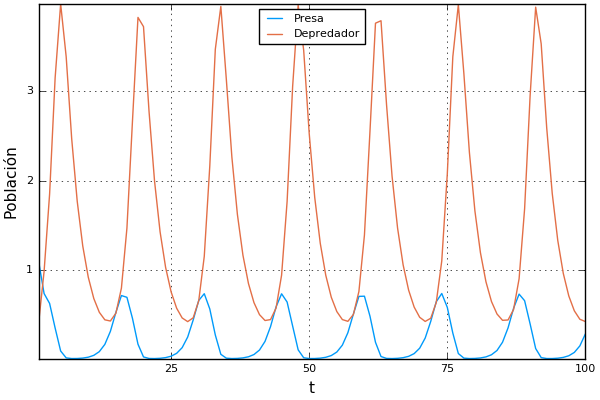

In [83]:
Plots.plot(Orbita([1.10,0.40], parametros1, 100)[3],Orbita([1.10,0.40], parametros1, 100)[1],xlabel="t",ylabel="Población",label="Presa")
Plots.plot!(Orbita([1.10,0.40], parametros1, 100)[3],Orbita([1.10,0.40], parametros1, 100)[2],label="Depredador")


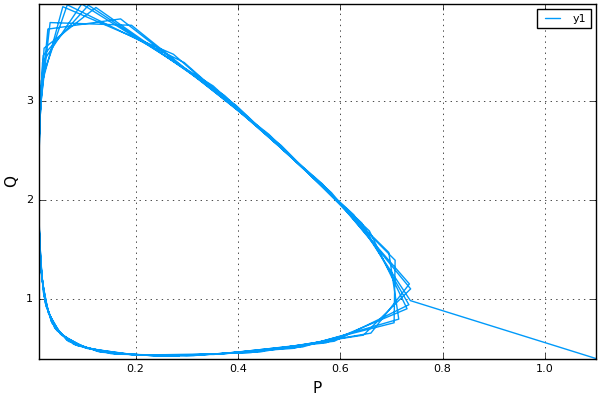

In [84]:
Plots.plot(Orbita([1.10,0.40],parametros1,100)[1],Orbita([1.10,0.40],parametros1,100)[2],xlabel="P",ylabel="Q")


El segundo ejemplo muestra un comportamiento distinto, ya que las poblaciones no llegan a un punto de equilibrio sino que se quedan en un ciclo: cuando crece mucho la población de depredadores, se acaban a las presas, por lo que ya no tienen de qué alimentarse y se empiezan a morir. Esto le da oportunidad a la población de presas de crecer, lo cual le da alimento al depredador y entonces esta población crece. Una vez que la población de depredadores es alta otra vez, el ciclo se vuelve a repetir. 



Para indagar más en la dinámica de nuestro sistema dinámico, nos concentraremos en los parámetros $r=1$ $s=0.5$, $u=0.7$ y $v=1.6$ analizando qué es lo que pasa cuando variamos uno a uno los parámetros. 

In [85]:
  x=[1.10,0.40];

Aquí variamos el parámetro $r$ alrededor de $(1,0.5,0.7,1.6)$


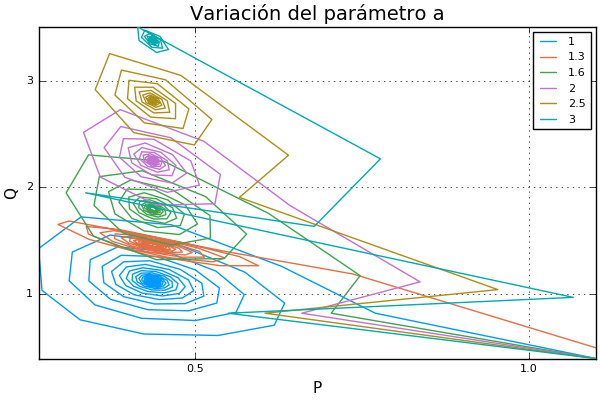

In [86]:
Plots.plot(Orbita([1.10,0.40],[1,0.5,0.7,1.6],200)[1],Orbita([1.10,0.40],[1,0.5,0.7,1.6],200)[2],xlabel="P",ylabel="Q",label="1")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,1.6],100)[1],Orbita([1.3,0.5,0.7,1.6],parametros,100)[2],label="1.3")
Plots.plot!(Orbita([1.10,0.40],[1.6,0.5,0.7,1.6],100)[1],Orbita([1.10,0.40],[1.6,0.5,0.7,1.6],100)[2],label="1.6")
Plots.plot!(Orbita([1.10,0.40],[2,0.5,0.7,1.6],100)[1],Orbita([1.10,0.40],[2,0.5,0.7,1.6],100)[2],label="2")
Plots.plot!(Orbita([1.10,0.40],[2.5,0.5,0.7,1.6],100)[1],Orbita([1.10,0.40],[2.5,0.5,0.7,1.6],100)[2],label="2.5")
Plots.plot!(Orbita([1.10,0.40],[3,0.5,0.7,1.6],100)[1],Orbita([1.10,0.40],[3,0.5,0.7,1.6],100)[2],label="3",title="Variación del parámetro a")

La dinámica no es muy interesante, ya que hay un punto fijo que cambia con respecto a los depredadores pero no con respecto a las presas. 

Aquí variamos el parámetro $u$ alrededor de $(1,0.5,0.7,1.6)$


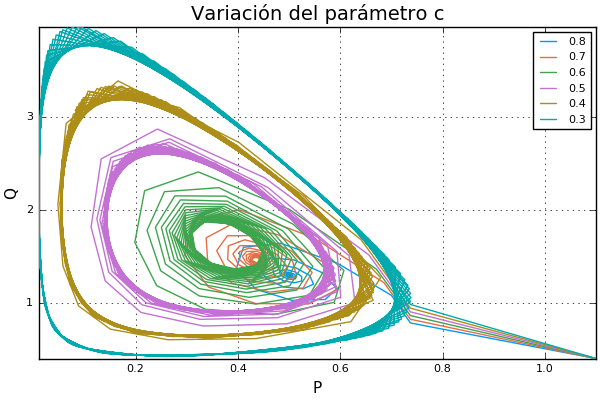

In [87]:
Plots.plot(Orbita([1.10,0.40],[1.3,0.5,0.8,1.6],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.8,1.6],100)[2],xlabel="P",ylabel="Q",label="0.8")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,1.6],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,1.6],100)[2],label="0.7")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.6,1.6],200)[1],Orbita([1.10,0.40],[1.3,0.5,0.6,1.6],200)[2],label="0.6")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.5,1.6],200)[1],Orbita([1.10,0.40],[1.3,0.5,0.5,1.6],200)[2],label="0.5")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.4,1.6],200)[1],Orbita([1.10,0.40],[1.3,0.5,0.4,1.6],200)[2],label="0.4")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.3,1.6],200)[1],Orbita([1.10,0.40],[1.3,0.5,0.3,1.6],200)[2],label="0.3",title="Variación del parámetro c")


Lo que pasa en este caso es mucho más interesante. Al variar $u$ pasamos de tener un punto punto atractor a ciclos atractores. 

Aquí variamos $s$ alrededor del mismo punto


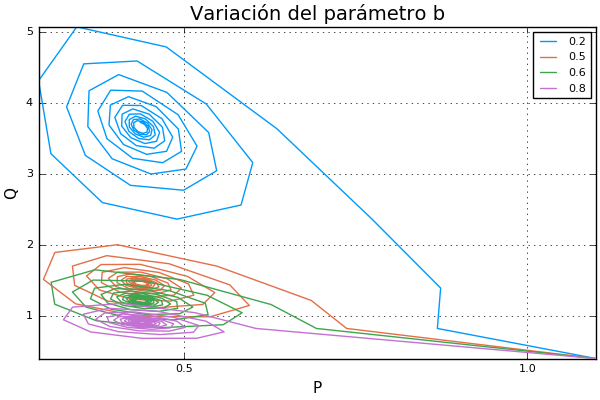

In [88]:
Plots.plot(Orbita([1.10,0.40],[1.3,0.2,0.7,1.6],100)[1],Orbita([1.10,0.40],[1.3,0.2,0.7,1.6],100)[2],xlabel="P",ylabel="Q",label="0.2")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,1.6],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,1.6],100)[2],label="0.5")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.6,0.7,1.6],100)[1],Orbita([1.10,0.40],[1.3,0.6,0.7,1.6],100)[2],label="0.6")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.8,0.7,1.6],100)[1],Orbita([1.10,0.40],[1.3,0.8,0.7,1.6],100)[2],label="0.8",title="Variación del parámetro b")

Y aquí variamos $v$


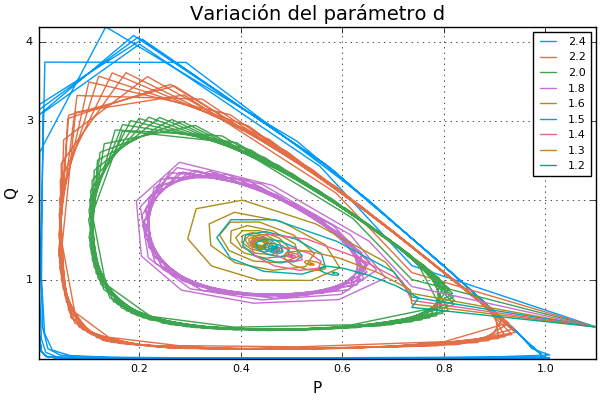

In [89]:
Plots.plot(Orbita([1.10,0.40],[1.3,0.5,0.7,2.4],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,2.4],100)[2],xlabel="P",ylabel="Q",label="2.4")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,2.2],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,2.2],100)[2],label="2.2")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,2],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,2],100)[2],label="2.0")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,1.8],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,1.8],100)[2],label="1.8")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,1.6],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,1.6],100)[2],label="1.6")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,1.5],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,1.5],100)[2],label="1.5")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,1.4],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,1.4],100)[2],label="1.4")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,1.3],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,1.3],100)[2],label="1.3")
Plots.plot!(Orbita([1.10,0.40],[1.3,0.5,0.7,1.2],100)[1],Orbita([1.10,0.40],[1.3,0.5,0.7,1.2],100)[2],label="1.2",title="Variación del parámetro d")



El cambio que observamos en la dinámica del sistema dinámico al variar $u$ y $v$ alrededor de los parámetros que elegimos parece indicarnos una bifurcación, es decir, un cambio cualitativo en la dinámica. Ahora haremos el diagrama de bifurcación correspondiente al variar únicamente $u$. 

In [90]:
T=[]
P=[]
Q=[]
for c in 0.5:0.001:0.7
    x=[1.10,0.40]
    parametros=[1.3,0.5,c,1.6]
    for m in Orbita(x,parametros,1000)[1][901:1000]
        push!(P,m)
    end
    for m in Orbita(x,parametros,1000)[2][901:1000]
        push!(Q,m)
    end
    for i in 1:100
        push!(T,c)
    end
end



Hacemos 1,000 iteraciones, graficamos  las útimas 100:


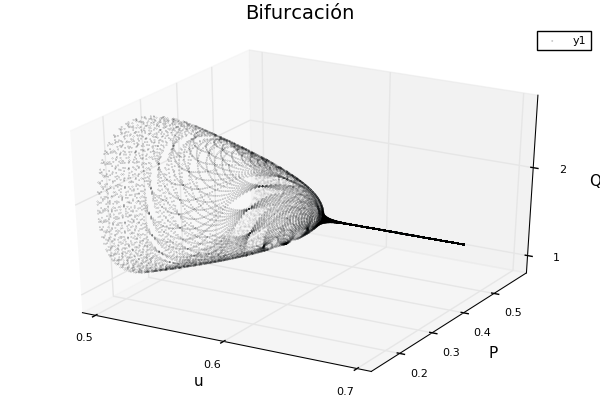

In [91]:
Plots.scatter(T,P,Q,markersize=0.1,xlabel="u",ylabel="P",zlabel="Q",title="Bifurcación")

In [92]:
T=[]
P=[]
Q=[]
for c in 0.55:0.0001:0.65
    x=[1.10,0.40]
    parametros=[1.3,0.5,c,1.6]
    for m in Orbita(x,parametros,10000)[1][9901:10000]
        push!(P,m)
    end
    for m in Orbita(x,parametros,10000)[2][9901:10000]
        push!(Q,m)
    end
    for i in 1:100
        push!(T,c)
    end
end




Hacemos 10,000 iteraciones, guardamos las últimas 100:


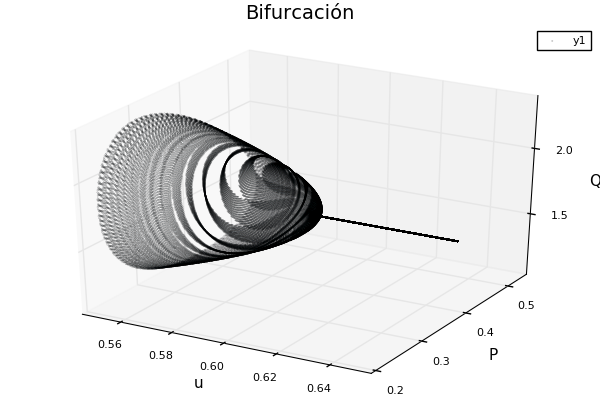

In [93]:
Plots.scatter(T,P,Q,markersize=0.1,xlabel="u",ylabel="P",zlabel="Q",title="Bifurcación")

In [94]:
T=[]
P=[]
Q=[]
for c in 0.55:0.0001:0.65
    x=[1.10,0.40]
    parametros=[1.3,0.5,c,1.6]
    for m in Orbita(x,parametros,10000)[1][9001:10000]
        push!(P,m)
    end
    for m in Orbita(x,parametros,10000)[2][9001:10000]
        push!(Q,m)
    end
    for i in 1:1000
        push!(T,c)
    end
end

Lo mismo que el diagrmana anterior, pero graficamos los últimos 1000 puntos de cada órbita. 


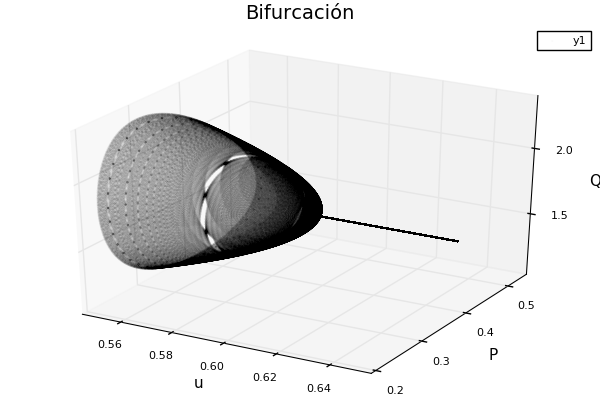

In [95]:
Plots.scatter(T,P,Q,markersize=0.01,xlabel="u",ylabel="P",zlabel="Q",title="Bifurcación")


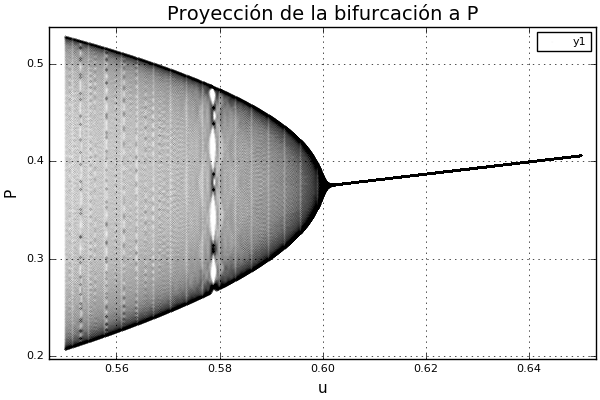

In [96]:
Plots.scatter(T,P,markersize=0.01,xlabel="u",ylabel="P",title="Proyección de la bifurcación a P")

Podemos ver que en este diagrama de bifurcaciones también hay ventanas periódicas, y que seguramente tiene muchas otras características interesantes. 

A esta bifurcación se le conoce como *bifurcación de Hopf*, donde un punto atractor pasa a ser uno repulsor con un ciclo atractor. Veamos qué pasa con nuestro punto fijo analíticamente. Más adelante veremos que nuestros puntos fijos son tres, el que nos interesa en este caso es:

$E2 =\left[\frac{u}{v} ,\frac{r}{s}\left(1-\frac{u}{ v}\right)\right]$

Recordemos que en el caso uno-dimensional, el valor absoluto de la derivada en los puntos fijos nos habla acerca de su estabiliadad. El análogo para nuestro sistema de dos dimensiones en analizar la matriz Jacobiana, específicamente el valor absoluto de sus eigenvalores. La matriz Jacobiana del sistema, evaluado en nuestro punto fijo es:

$$
J(E_2)=
\begin{pmatrix}
1-\frac{ru}{v} & -\frac{su}{v} \\ 
 \frac{r(-u+v)}{s}& 1
\end{pmatrix}
$$


In [97]:
EigenValores=[]

C=[]
for c in 0.4:0.0001:0.8
    parametros=[1.3,0.5,c,1.6]
    r=parametros[1]
    s=parametros[2]
    u=parametros[3]
    v=parametros[4]
    a=1-(r*u/v)
    b=(-(s*u)/v)
    c=r*(-u+v)/s
    d=1
    M=[a b;c d]
    push!(EigenValores,eig(M)[1][1])
    push!(EigenValores,eig(M)[1][2])
    push!(C,c)
    
end
    


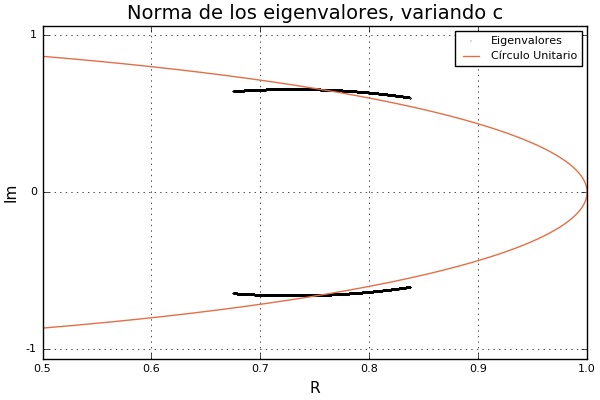

In [98]:
Plots.scatter(real(EigenValores),imag(EigenValores),xlabel="R",ylabel="Im",markersize=0.1,label="Eigenvalores")
Plots.plot!(cos(0:0.01:2*pi),sin(0:0.01:2*pi),label="Círculo Unitario",title="Norma de los eigenvalores, variando c")
xlims!(0.5,1)




Este cambio en la norma de los eigevalores del Jacobiano evaluado en nuestro punto fijo nos explican la bifurcación que observamos: Cuando los eigenvalores salen del círculo unitario, el punto fijo se vuelve un repulsor. 

¡Toda esta rica dinámica la encontramos variando un sólo parámetro y dejando los demás fijos! Las posibilidades son infinitas, y posiblemente otras elecciones de parámetros tendrán dinámicas diferentes- este fue sólo un estudio de un caso muy particular de parámetros que muestran ciclos. Y esto, para un modelo que asume cosas muy básicas de poblaciones.

In [99]:
"""
    CP_Simple(Xt,constantes)

Dado un vector con los valores de la población de presas y depredadores 
Xt=[P,Q], realiza el siguiente paso con el modelo simple.

"""
function CP_Simple(Xt::Vector{Float64},constantes::Vector{Float64})
    
    @assert length(Xt)==2 && length(constantes) == 5
    
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    K = constantes[5]
    
    #Asignación del paso 0
    P0 = Xt[1]
    Q0 = Xt[2]
    #Evaluación del modelo
    P1 = P0*(1+r*(1-P0/K))-s*P0*Q0
    Q1 = (1-u)*Q0+v*P0*Q0
    
    #Resultados
    [P1,Q1]   
end

CP_Simple

In [100]:
"""
    mapeo2D_lista(F,X_0,constantes,t)
Dada una función `F(X_0,constantes)` que define un mapeo de 2 dimensiones
un punto inicial `X_0` y las `constantes` en forma de vector, regresa dos
vectores con los `t` iterados del mapeo para cada dimensión.

"""

function mapeo2D_lista(F::Function , X_0::Vector{Float64},constantes,t::Int64)
    @assert length(X_0)==2 && t > 0
    
    X0 = X_0
    #Definición de los vectores para almacenar resultados.
    Ps = [X0[1]]
    Qs = [X0[2]]
    
    for i in 1:t-1
        X0 = F(X0,constantes)
        push!(Ps,X0[1])
        push!(Qs,X0[2])
    end
    Ps,Qs
end

mapeo_PQ_ts(v_0,r,s,u,v,t) = mapeo_PQ_ts(v_0,r,s,u,v,1.0,t)

mapeo_PQ_ts (generic function with 1 method)

## Puntos fijos

Buscamos $(P,Q)$ tal que 

$$
\begin{aligned}
P &= P \left( 1+r \left( 1-P \right)\right)-s P Q\\
Q &= (1-u)Q+v P Q
\end{aligned}
$$

Los puntos fijos son:


\begin{aligned}
E_0 &= [0.0 ,0.0]\\
E_1 &= [1.0 ,0.0]\\
E_2 &= \left[\frac{u}{v} ,\frac{r}{s}\left(1-\frac{u}{ v} \right) \right]
\end{aligned}

Como sólo nos interesan los puntos positivos, necesitamos que $\frac{u}{v}<1$ i.e. $u<v$

Recordemos que cuando tenemos mapeos de una dimensión, la derivada en un punto fijo nos habla acerca de la estabilidad de ese punto. El análogo en modelos de dos dimensiones es el jacobiano de la función en el punto fijo. 

El jacobiano del mapeo para $E_2$:

$$
J(E_2)=
\begin{pmatrix}
1-\frac{ru}{v} & -\frac{su}{v} \\ 
 \frac{r(-u+v)}{s}& 1
\end{pmatrix}
$$

La ecuación característica del Jacobiano:

$$\lambda^2+r_1\lambda+r_2=0$$

con $r_1=-trJ=-2+\frac{ru}{v}$, $r_2=detJ=1+\frac{ru(-1-u+v)}{v}$:

Entonces:

$$
\lambda_{1,2}=-\frac{r_1}{2}\pm\sqrt{\Delta}=1-\frac{ru}{2v}\pm\sqrt{\Delta}
$$

donde $\Delta=\left(\frac{r_1}{2}\right)^2-r_2=\frac{ru\left(ru+4uv-4v^2\right)}{4v^2}$

Si $\Delta>0$, entonces $r_\Delta>-\frac{4(uv-v^2)}{u}$, de lo contrario los eigenvalores son complejos.

Seguramente cuando el valor de $\Delta$ cambie de imaginario a real ocurrirá un cambio de comportamiento.


Con los 
$$
\begin{aligned}
\lambda_{1,2} = 1 &\Rightarrow  r_{\lambda_{1,2}=1}=0 \\
\lambda_{1,2} =0 &\Rightarrow  r_{\lambda_{1,2}=0}=\frac{v_{\lambda_1=0}}{u+u^2-uv}\\
\lambda_{1,2} =-1 &\Rightarrow  r_{\lambda_{1,2}=-1}=\frac{4v}{u(2+u-v)}
\end{aligned}
$$


Ahora, igualamos 
$$
\begin{aligned}
r_\Delta=r_{\lambda_{1,2}=0} &\Rightarrow  v_{\lambda_{1,2}=0}=\frac{1}{2}(1+2u) \\
r_\Delta=r_{\lambda_{1,2}=1} &\Rightarrow  v_{\lambda_{1,2}=0}=1+u
\end{aligned}
$$

Tenemos que revisar tres intervalos, para distintas $r's$, con énfasis en $r_\Delta$. Como observación, vemos que la constante $s$ no define la dinámica, simplemente se limita a cambiar la posición del punto de equilibro $E_2$.



## Bifurcaciones

Para encontrar las bifuraciones debemos fijar los parámetros y variar solamente uno de los parámetros, en este caso $r$.

In [101]:
#Nuevo método de la función mapeo2D_lista, para quedarse sólo con cierto número de valores finales `tout`
function mapeo2D_lista(F::Function , X_0::Vector{Float64},constantes,tin::Int64,tout::Int64)
    
    @assert length(X_0)==2 &&  tin > 0 && tout > 0
    
    X0 = X_0
    
    for i in 1:tin
        X0 = F(X0,constantes)
    end
    
    mapeo2D_lista(F , X0, constantes,tout)

end

# Otro metodo, que emplea una función para determinar el punto inicial donde empieza el mapeo.
function mapeo2D_lista(F::Function , p::Function,constantes,tin::Int64,tout::Int64)
    
    X0 = p(constantes)
    
        mapeo2D_lista(F, X0,constantes,tin,tout)
end

mapeo2D_lista (generic function with 3 methods)

In [102]:
function diagbifurc2D(F::Function, X0, rrange::Range{Float64}, tin::Int64,tout::Int64)
    
    #Definición de variables
    X = Vector{Float64}(tout)
    Y = Vector{Float64}(tout)
    
    xx = Array{Float64,2}(tout, length(rrange))
    yy = Array{Float64,2}(tout, length(rrange))
    
    for ic in eachindex(rrange)
        r = rrange[ic]
        X,Y = mapeo2D_lista(F, X0,r,tin,tout)
        
        xx[:,ic] = X
        yy[:,ic] = Y
    end
    
    return xx,yy
    
end    

diagbifurc2D (generic function with 1 method)

In [103]:
#Función para generar los valores del punto fijo E_2
function pE2(constantes)
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    [u/v,r*(1-u/v)/s]
end

pE2 (generic function with 1 method)

### Doblamiento de periodo.
Primero, si tenemos $Q=0.0$, entonces el mapeo queda así:

$$P_{t+1} = P_t \left( 1+r \left( 1-P_t \right)\right)$$

$$P_{t+1} =  r+P_t-rP_t^2 $$

Se debería esperar un comportamiento muy similar al del mapeo cuadrático, y en efecto su diagrama de bifuraciones es el mismo. 


In [104]:
#Debido a una multitud de gráficos similares, esta función ayuda a graficar.
function plot1(F::Function, X_0, range::Range, tin::Int64, tout::Int64, titulo::String)
    
    Ps,Qs=diagbifurc2D(F,X_0, range, tin,tout)
    Rs = ones(size(Ps)[1])*range'
    
    #Cambio de forma de las matrices.
    Ps = reshape(Ps, size(Ps)[1]*size(Ps)[2]);
    Qs = reshape(Qs, size(Qs)[1]*size(Qs)[2]);
    Rs = reshape(Rs, size(Rs)[1]*size(Rs)[2]);
    
    #Plots
    PyPlot.plot(Rs,Ps,"b,",label=(L"P"))
    PyPlot.plot(Rs,Qs,"r,",label=(L"Q"))
    xlabel(L"r")
    ylabel(L"P_{\infty},Q_{\infty}")
    title(titulo)
    legend()
    #Resultados, en caso de usarse
    Rs,Ps,Qs
end

plot1(F::Function, X_0, range::Range, titulo::String)=plot1(F, X_0, range,10000,500, titulo::String)

plot1 (generic function with 3 methods)

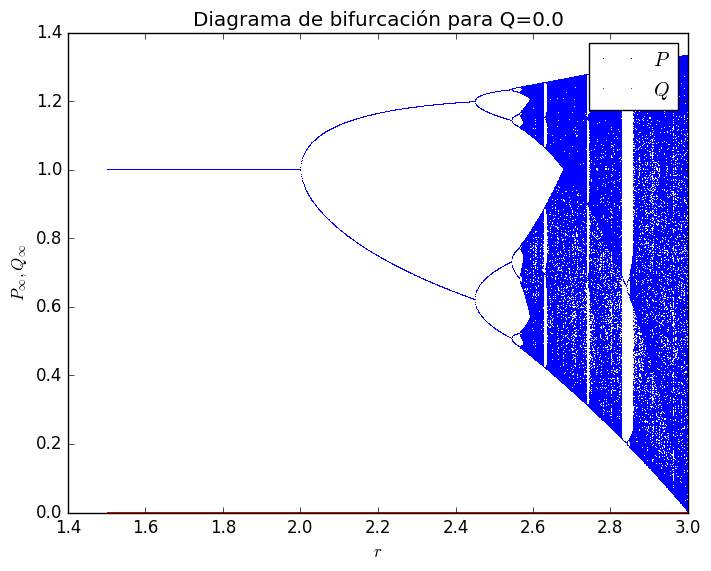

In [105]:
rrange1 = 1.5:2.0^-10:3.0
s,u,v,K = 3.0,1.25,1.95,1.0
X0 = [0.641,0.000]

F1(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);

plot1(F1, X0, rrange1, "Diagrama de bifurcación para Q=0.0");

Obtenemos un diagrama de bifurcación de doblamiento de periodo. Sin embargo, no nos interesa el análisis de éste, debido a que lo importante aquí es la dinámica de las dos componentes, no sólo de una. Analizaremos ahora la dinámica para puntos cercanos a $Q=0$

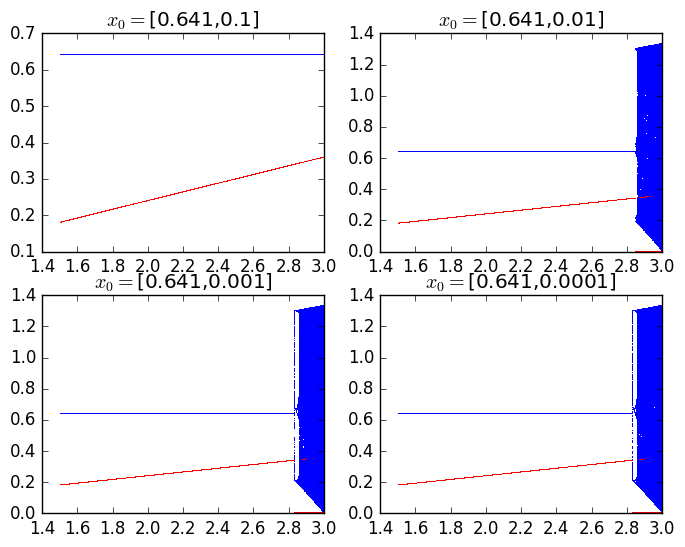

In [106]:
for i in 1:4
    X0 = [0.641,10.0^(-i)]
    Ps4,Qs4=diagbifurc2D(F1,X0, rrange1, 10000,500)
    Rs4 = ones(size(Ps4)[1])*rrange1'

    # Esto cambia las matrices en vectores; ayuda un poco para los dibujos
    Ps4 = reshape(Ps4, size(Ps4)[1]*size(Ps4)[2]);
    Qs4 = reshape(Qs4, size(Qs4)[1]*size(Qs4)[2]);
    Rs4 = reshape(Rs4, size(Rs4)[1]*size(Rs4)[2]);
    
    subplot(220+i)
    PyPlot.plot(Rs4,Ps4,"b,")
    PyPlot.plot(Rs4,Qs4,"r,")
    if i==3 && i==4 
        xlabel(L"r")
    end
    if i==1 && i==3 
        ylabel(L"P_{\infty}")
    end
    title(L"x_0="*"$X0")
    
end

Observemos que alrededor del $r\sim2.8$, ocurre un cambio de comportamiento. Crearemos una función para determinar este cambio de régimen.

In [107]:
"""
    ordenar_eliminar_val_rep!(vec::Vector{Float64},ϵ::Float64)
Dado un vector `vec`, ordena y quita los elementos repetidos del vector con una tolerancia `ϵ`
"""
function ordenar_eliminar_val_rep!(vector::Vector{Float64},ϵ::Float64)
    
    N=length(vector)
    
    sort!(vector) #Ordena el vector.
    
    k = 1
    
    for i in 2:N          
        if abs(vector[k]-vector[k+1]) <= ϵ  #Obseva si los valores difieren más allá de epsilón.
            deleteat!(vector,k)             #Elimina el valor repetido.            
        else
            k=k+1
        end     
    end
    
    vector
    
end

#Método con ϵ predefinida.

ordenar_eliminar_val_rep!(vec)=ordenar_eliminar_val_rep!(vec,1e-5)

ordenar_eliminar_val_rep! (generic function with 2 methods)

Ahora, creamos una función que busque un aumento súbito de elementos en dos vectores, en un intervalo.

In [108]:
function mapeo2D_bif(F::Function , X_0, rrange::Range, tin::Int64,tout::Int64)
    #variable para almacenar el resultado
    rresultado=Float64
    
    for i in length(rrange)-1
        #función para r
        r(j)=rrange[j]
        
        #Definición de los dos vectores.
        vec1P,vec1Q=mapeo2D_lista(F, X_0,r(i)  ,tin,tout)
        vec2P,vec1Q=mapeo2D_lista(F, X_0,r(i+1),tin,tout)
        
        #Ordenamiento de los vectores.
        ordenar_eliminar_val_rep!(vec1P)
        ordenar_eliminar_val_rep!(vec2P)
        
        #Condición.        
        if length(vec1P)!=length(vec2P)
            rresultado=(r(i)+r(i+1))/2
            break
        end        
    end
    
    rresultado
end

mapeo2D_bif (generic function with 1 method)

Busquemos la región donde ocurre la bifurcación.

In [109]:
rrange1=2.8:2.0^-20:2.85
mapeo2D_bif(F1,[0.641,0.01], rrange1, 10000,500)

2.8499987602233885

In [110]:
mapeo2D_bif(F1,[0.641,0.001], rrange1, 10000,500)

2.8499987602233885

In [111]:
mapeo2D_bif(F1,[0.641,0.0001], rrange1, 10000,500)

2.8499987602233885

Observamos, que, como era de esperarse, la constante parece invariante en esa región. Grafiquemos el diagrama de fase en ese punto.

In [112]:
#Otra función para graficos recurrentes
function plot2(mapeo::Function, X_0, constantes, t::Int64, titulo::String,tipo::String)
    Ps,Qs = mapeo2D_lista(mapeo,X_0,constantes,t)
    
    #plots
    PyPlot.plot(Ps,Qs,tipo)
    xlabel(L"P")
    ylabel(L"Q")
    title(titulo)
    return Ps,Qs    
end

#Función con el tipo de gráfico estándar
plot2(mapeo::Function, X_0, constantes, t::Int64, titulo::String)=plot2(mapeo, X_0, constantes, t, titulo,"b")

#Función con varias cosas ya definidas.
plot2(mapeo::Function, X_0, constantes, titulo::String)=plot2(mapeo, X_0, constantes,100, titulo)

#Para ignorar los primeros tin
function plot2(mapeo::Function, X_0, constantes, tin::Int64,tout::Int64, titulo::String,tipo::String)
    Ps,Qs = mapeo2D_lista(mapeo,X_0,constantes,tin,tout)
    
    #plots
    plot(Ps,Qs,tipo)
    xlabel(L"P")
    ylabel(L"Q")
    title(titulo)
    return Ps,Qs    
end

plot2 (generic function with 4 methods)

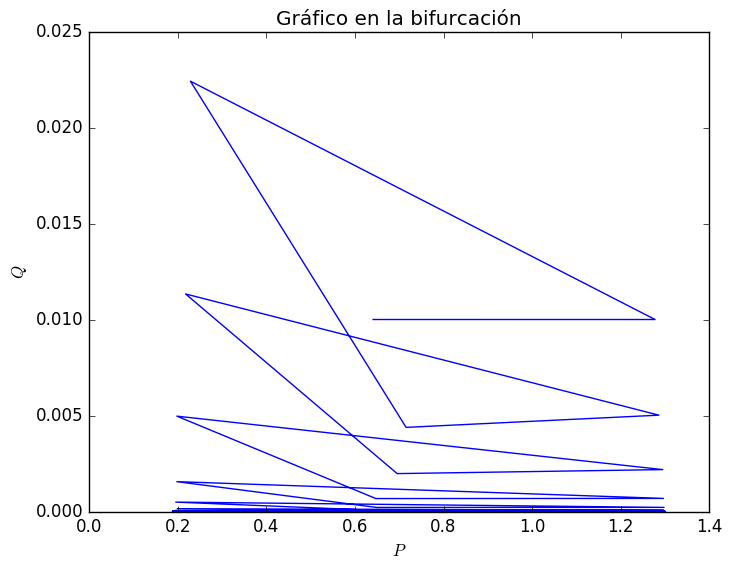

In [113]:
r = 2.8499987602233885
const1 = [r,s,u,v,K]
X0 = [0.641,0.01]

plot2(CP_Simple,X0,const1,"Gráfico en la bifurcación");


Se tiene un caso, que parece ser de periódo 3, en el que las depredadores se extinguen, y queda el comportamiento oscilante de las presas, cuyo equilibrio se define por el diagrama de bifurcación.

## Bifurcación del punto de equilibrio. Otro caso.

Si ahora, buscamos cerca de las zona donde los eigenvalores del Jacobiano en el punto de equilibro $E_2$ se vuelven imaginarios. Es decir $r_\Delta<-\frac{4(uv-v^2)}{u}$

In [114]:
s,u,v,K = 3.0,1.25,1.95,1.0
-4*(u*v-v^2)/u

4.367999999999999

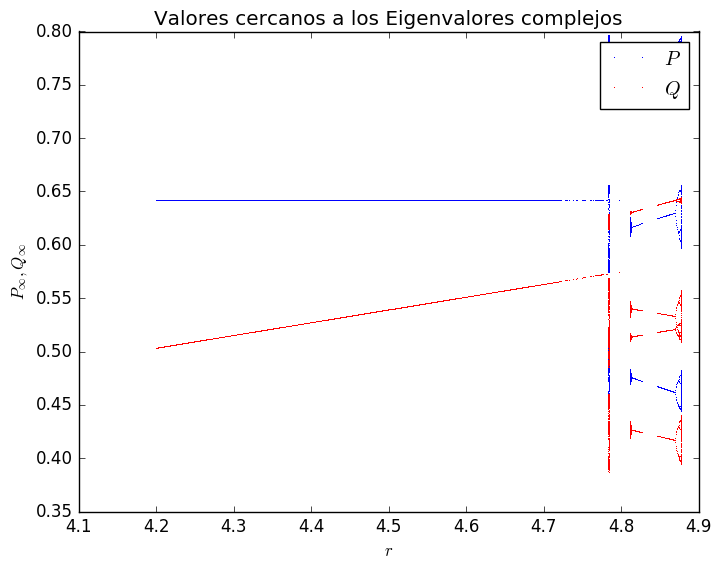

In [115]:
rrange1 = 4.2:2.0^-11:5.0

#La función p sirve para definir valores iniciales cercanobs al punto de equilibrio
p4(r)=[0.641,pE2([r,s,u,v])[2]-0.061]

plot1(F1, p4, rrange1, "Valores cercanos a los Eigenvalores complejos");

La dinámica en el punto parece ser normal, las condiciones iniciales se van al punto de equilibrio. Sin embargo, aparece una zona de comportamiento anormal.

In [116]:
#Otro metodo que permite graficar lineas que separan regiones
function plot1(F::Function, X_0, range::Range, A::Vector{Float64}, titulo::String)
    for i in 1:length(A)
        plot([A[i],A[i]],[0.36,0.80],"g")
    end
    plot1(F, X_0, range, titulo)
end

plot1 (generic function with 3 methods)

In [117]:
rrange1 = 4.76:2.0^-13:4.9

#La función p sirve para definir valores iniciales cercanobs al punto de equilibrio
p4(r)=[0.641,pE2([r,s,u,v])[2]-0.061]

#Lineas que dividen las regiones
A=[4.782921348,4.785393258,4.810337079,4.814157303,4.863595506,4.877752809]

Rs4,Ps4,Qs4=plot1(F1, p4, rrange1, A, "Zona de bifurcaciones en 2 dimensiones");

LoadError: LoadError: UndefVarError: plot not defined
while loading In[117], in expression starting on line 9

Observamos que tenemos regiones de comportamiento extraño, y ¡Una zona con bifurcaciones en 2 dimensiones!. Enseguida graficamos en dos dimensiones el diagrama de bifurcación.

In [118]:
plot3D(Rs4,Ps4,Qs4,"b,")
xlabel(L"r")
ylabel(L"P_\infty")
zlabel(L"Q_\infty")
title("Zona de bifurcaciones en el espacio")

LoadError: LoadError: UndefVarError: Rs4 not defined
while loading In[118], in expression starting on line 1

Tenemos tres regiones de interés, marcadas entre líneas verdes:

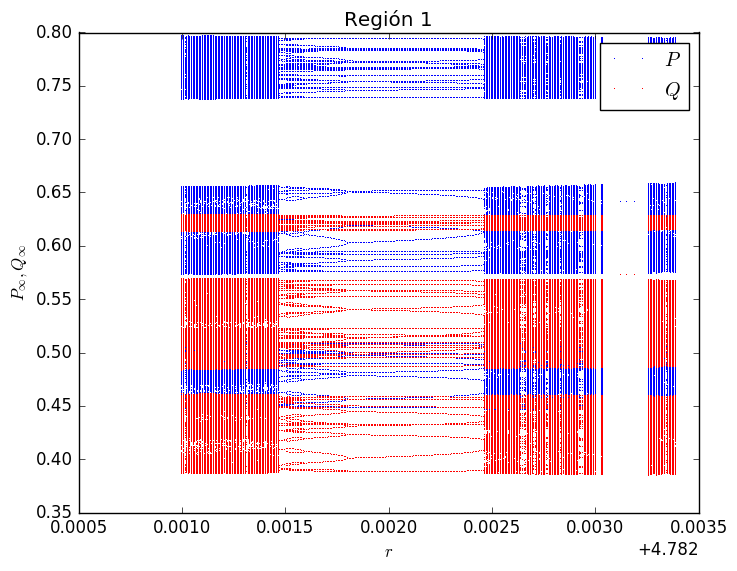

In [119]:
rrange1 = 4.782921348:2.0^-17:4.785393258
Rs,Ps6,Qs6 = plot1(F1, p4, rrange1, 100000,3000, "Región 1");

Se observa una región de extrañas bifurcaciones, entre zonas muy ruidosas. Parece ser la superposición de distintos comportamientos.

La región 2 tiene un comportamiento más sencillo de definir.

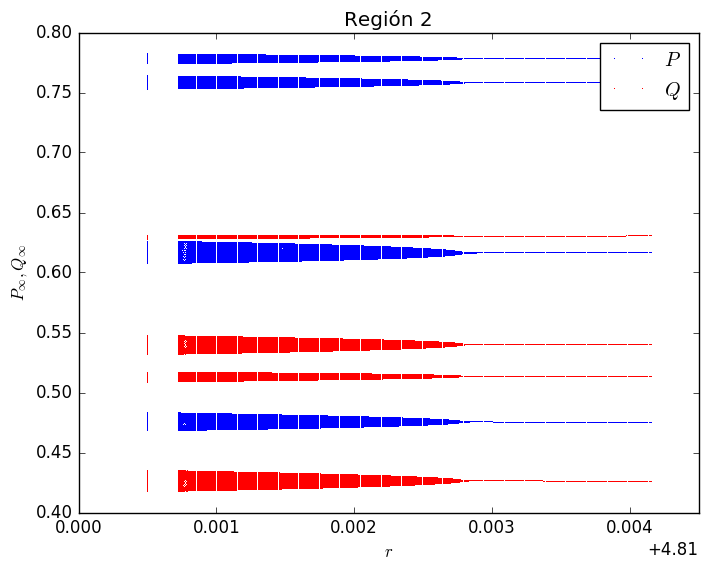

In [120]:
rrange1 = 4.810337079:2.0^-17:4.814157303
plot1(F1, p4, rrange1, 100000,3000, "Región 2");

En el siguiente gráfico vemos cómo hay una región donde el mapeo tiende a 4 zonas, que a medida que el valor de $r$ crece, se vuelven más cerradas.

In [121]:
r = 4.81+0.001
X0 =  p4(r)
plot2(F1, X0, r, 2000,500, "Curvas de convergencia en la región 2 con r=$r","b,");

LoadError: LoadError: UndefVarError: plot not defined
while loading In[121], in expression starting on line 3

Aquí ya las zonas están bastante cerradas.

In [122]:
r = 4.81+0.004
X0 =  p4(r)
plot2(F1, X0, r, 2000,500, "Curvas de convergencia en la región 2 con r=$r","b,");

LoadError: LoadError: UndefVarError: plot not defined
while loading In[122], in expression starting on line 3

In [123]:
plot2(mapeo::Function, X_0, constantes, t::Int64, titulo::String)

LoadError: LoadError: UndefVarError: mapeo not defined
while loading In[123], in expression starting on line 1

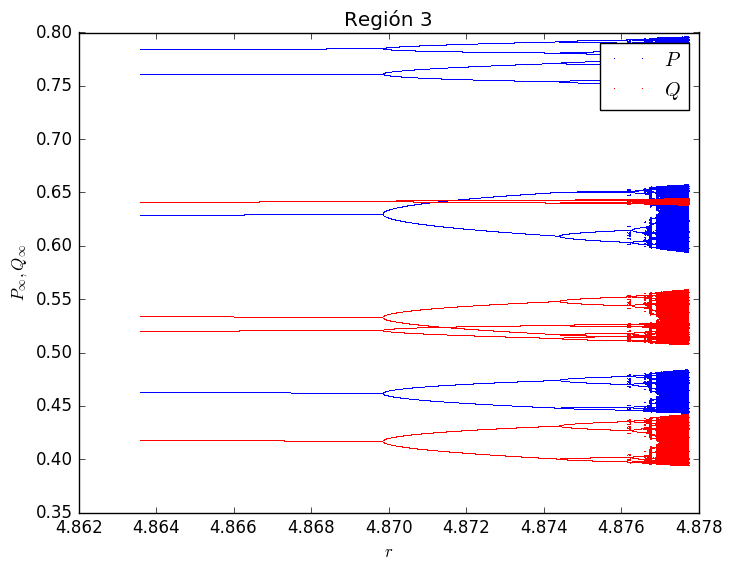

In [124]:
rrange1 = 4.863595506:2.0^-17:4.877752809
plot1(F1, p4, rrange1, 100000,3000, "Región 3");

En la región 3 tenemos un comportamiento muy similar al que ocurre en las zonas de doblamiento de periodo de una dimensión, pero en lugar de tener la bifurcación en un plano, la tenemos en el espacio.

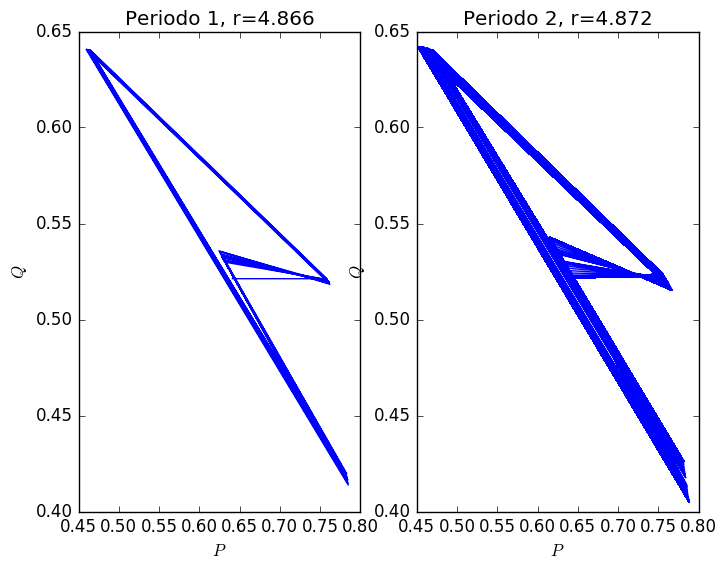

In [125]:
subplot(121)
r = 4.866
X0 =  p4(r)
plot2(F1, X0, r, 10000, "Periodo 1, r=$r");

subplot(122)
r = 4.872
X0 =  p4(r)
plot2(F1, X0, r, 10000, "Periodo 2, r=$r");

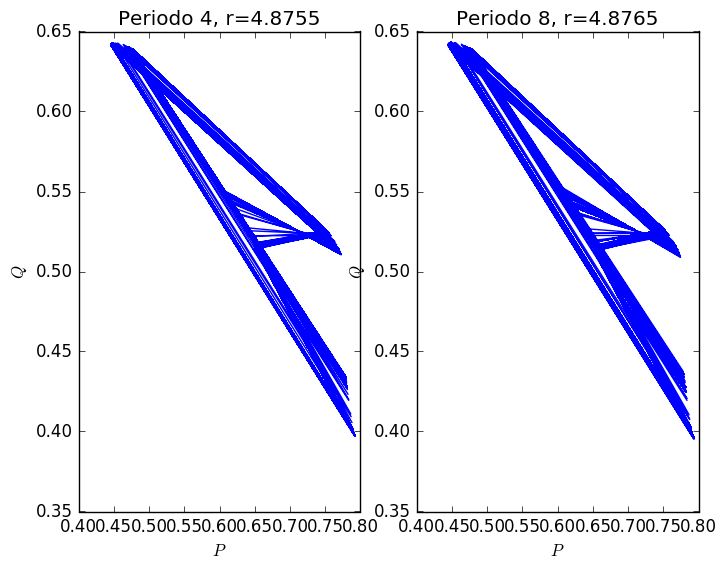

In [126]:
subplot(121)
r = 4.8755
X0 =  p4(r)
plot2(F1, X0, r, 10000, "Periodo 4, r=$r");

subplot(122)
r = 4.8765
X0 =  p4(r)
plot2(F1, X0, r, 10000, "Periodo 8, r=$r");

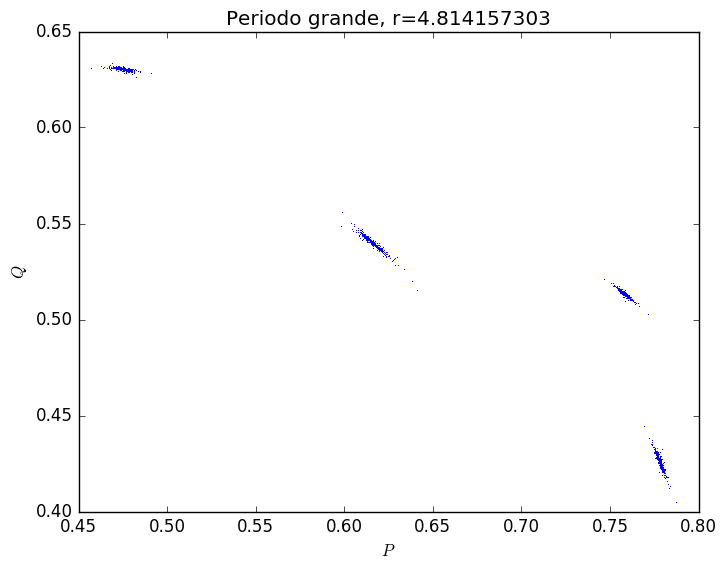

In [127]:
r = 4.814157303
X0 =  p4(r)
plot2(F1, X0, r, 10000, "Periodo grande, r=$r","b,");

Observamos que las bifurcaciones aumentan alrededor de 4 puntos de equilibrio.

## Valores cercanos a $v_{\lambda_{1,2}=0}=1+u$ ##

Iniciamos con las siguientes constantes, con  $v=1+u$

In [128]:
s,u,K = 3.0,0.25,1.0
v=1+u

const2 = [r,s,u,v,K]
p2(r)=pE2([r,s,u,v])-[0.0,0.06]
F2(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);

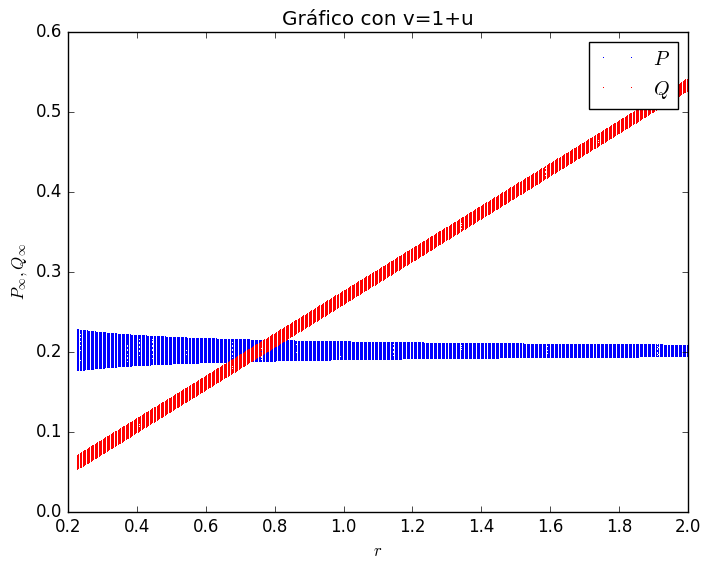

In [129]:
s,u,K = 3.0,0.25,1.0
v=1+u

const2 = [r,s,u,v,K]
rrange2 = 0.0:2.0^-8:2.0
plot1(F2, p2, rrange2, 20000,500, "Gráfico con v=1+u");

Se observa un comportamiento de trompeta, es decir, los valores tienden a una región ancha en lugar de a un punto. También vemos que mientras aumenta la $r$ la región donde converge el mapeo se va reduciendo. Grafiquemos un diagrama de fase.

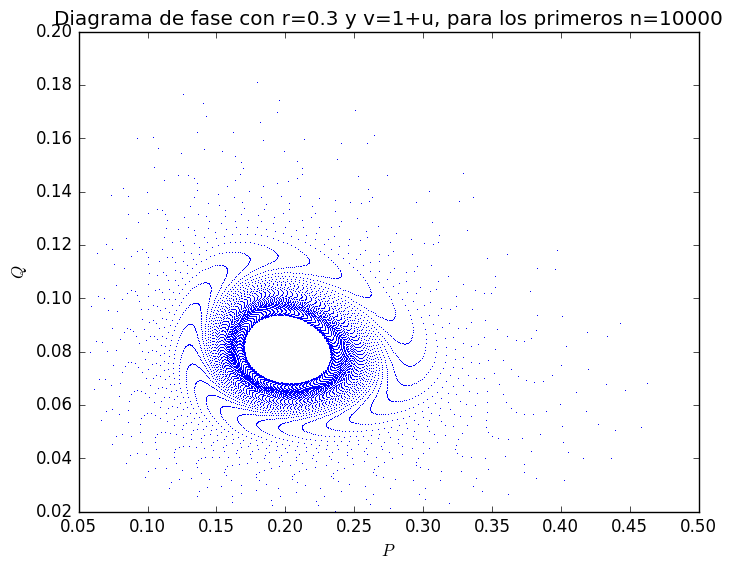

In [130]:
r = 0.3
X0 =  p2(r)
plot2(F2, X0, r, 10000, "Diagrama de fase con r=$r y v=1+u, para los primeros n=10000","b,");

Si se aumenta el número de iterados, entonces se puede ver a donde converge el mapeo, una región cerrada del espacio fase.

In [131]:
r = 0.3
X0 =  p2(r)
plot2(F2, X0, r, 20000,500, "Diagrama de fase con r=$r y v=1+u, para los primeros n=10000","b,");

LoadError: LoadError: UndefVarError: plot not defined
while loading In[131], in expression starting on line 3

Obtenemos sólo el contorno de las figuras cuando $P_\infty$ y $Q_\infty$. Se hace esto, simplemente obteniendo los máximos.

In [132]:
function mapeo2D_max(F::Function , E2::Function, X_0, rrange::Range, tin::Int64,tout::Int64)
    #variable para almacenar el resultado
    Pres=Float64[]
    Qres=Float64[]
    Rres=Float64[]
    
    for r in rrange        
        #Definición de los dos vectores.
        vecP,vecQ=mapeo2D_lista(F, X_0, r, tin,tout)
        
        #maximos
        maxP=maximum(vecP)-E2(r)[1]
        maxQ=maximum(vecQ)-E2(r)[2]
        
        
        if isnan(maxP) == false && isnan(maxQ) == false
            push!(Rres,r)
            push!(Pres,maxP)
            push!(Qres,maxQ)
        end
    end
    
    Rres, Pres,Qres
end

mapeo2D_max (generic function with 1 method)

También, debemos restar la posición del punto de equilibrio, para poder ver que tanto osc

In [133]:
rrange2 = 0.0:2.0^-8:10.0
pp2(r)=pE2([r,s,u,v])
Rs3,Ps3,Qs3 = mapeo2D_max(F2 ,pp2, p2, rrange2, 20000,500);


Utilizamos un paquete para ajustar la curva.

In [134]:
#Ajuste propuesto, r es la variable, p es un arreglo de constantes.
model(r, p) = p[1]*(r).^(-p[2]).+p[3]
#arreglo con el peso de los valores, en este caso todos son igualmente pesados.
w=ones(length(Rs3))
#Ajuste del modelo.
fitP = curve_fit(model, Rs3, Ps3,w)
fitQ = curve_fit(model, Rs3, Qs3,w);

El modelo electo es $ P,Q = a(r+b)^{-c}+d$

In [135]:
fitP

LsqFit.LsqFitResult{Float64}(0,[0.0132109,0.523979,-0.00187789,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],[2.42017e-5,3.7132e-5,0.000141916,7.54947e-5,6.88282e-5,5.53113e-5,7.67482e-5,9.11261e-5,7.35852e-5,8.29547e-5  …  -6.41735e-5,-6.4306e-5,-6.32613e-5,-6.36033e-5,-6.42276e-5,-6.81543e-5,-5.27696e-5,-5.05102e-5,-4.57274e-5,-3.7559e-5],[2.17705 0.0427022 … 0.0 0.0; 2.15764 0.0418342 … 0.0 0.0; … ; 0.300102 -0.00910715 … 0.0 0.0; 0.30004 -0.00910683 … 0.0 0.0])

In [136]:
P1=[0.0132109,0.523979,-0.00187789];

La curva para las presas está definida como $P_{contorno,\infty}\propto \frac{1}{\sqrt{r}}$

In [137]:
fitQ

LsqFit.LsqFitResult{Float64}(0,[0.0330781,0.0423991,-0.0247437,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],[0.000924559,0.000925741,0.000910719,0.000899367,0.000901003,0.000892826,0.000906815,0.00085843,0.000855748,0.000854023  …  0.000227346,0.00022827,0.00023102,0.000229443,0.000220243,0.000214723,0.000249909,0.000287662,0.000299672,0.00031944],[1.06498 0.0523033 … 0.0 0.0; 1.0642 0.0516636 … 0.0 0.0; … ; 0.907198 -0.0689323 … 0.0 0.0; 0.907183 -0.0689429 … 0.0 0.0])

In [138]:
Q1=[0.0330781,0.0423991,-0.0247437];

In [139]:
subplot(211)
PAs3=[model(r,P1) for r in Rs3]
plot(Rs3,Ps3,"r.",label=("Valores max"))
plot(Rs3,PAs3,label=("Ajuste"))
xlabel(L"r")
ylabel(L"P_{\infty}")
title("titulo")
legend()

subplot(212)

QAs3=[model(r,Q1) for r in Rs3]
plot(Rs3,Qs3,"r.",label=("Valores max"))
plot(Rs3,QAs3,label=("Ajuste"))
xlabel(L"r")
ylabel(L"Q_{\infty}")
title("titulo")
legend()

LoadError: LoadError: UndefVarError: plot not defined
while loading In[139], in expression starting on line 3

Naturalmente, si el valor de $v$ es ligeramente menor, se pierde este comportamiento, teniendo la convergencia de la bifurcación en un punto.

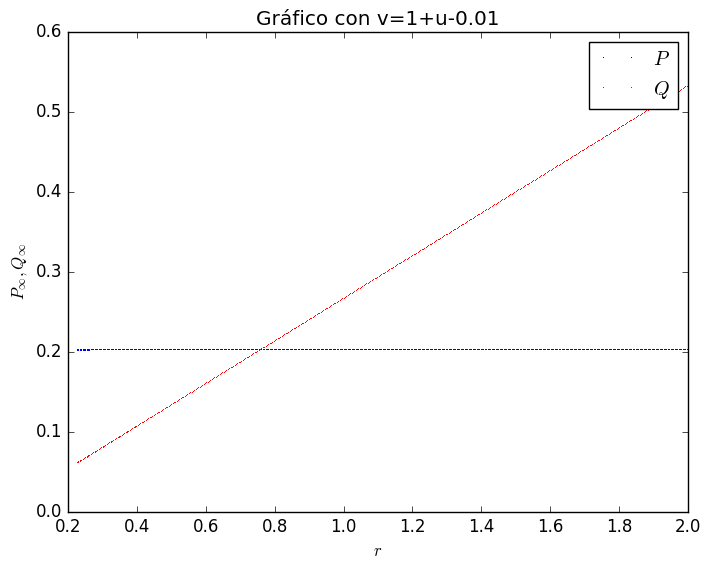

In [140]:
s,u,K = 3.0,0.25,1.0
v=1+u-0.01

const2 = [r,s,u,v,K]
rrange2 = 0.0:2.0^-8:2.0
plot1(F2, p2, rrange2, 20000,500, "Gráfico con v=1+u-0.01");

## Valores cercanos a $v=\frac{1}{2}(1+2u)$

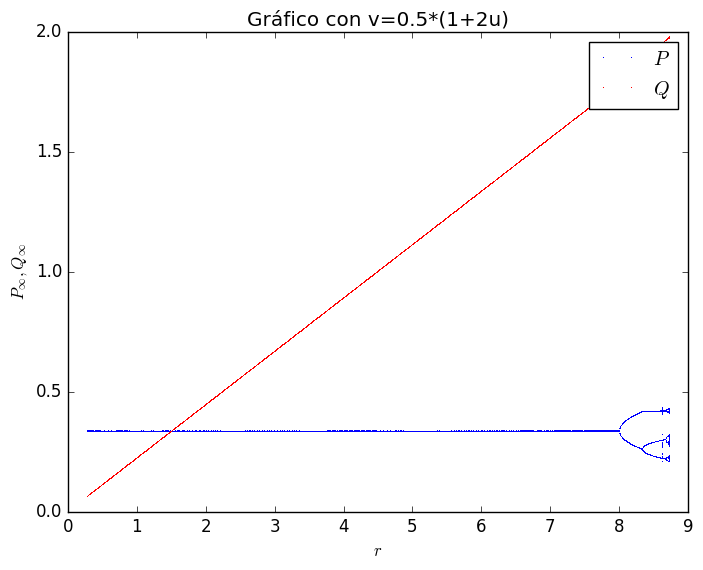

In [141]:
s,u,K = 3.0,0.25,1.0
v=0.5(1+2u)
p3(r)=pE2([r,s,u,v])-[0.0,0.06]
F3(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);
rrange3 = 0.0:2.0^-8:10.0
plot1(F3, p3, rrange3, 20000,500, "Gráfico con v=0.5*(1+2u)");

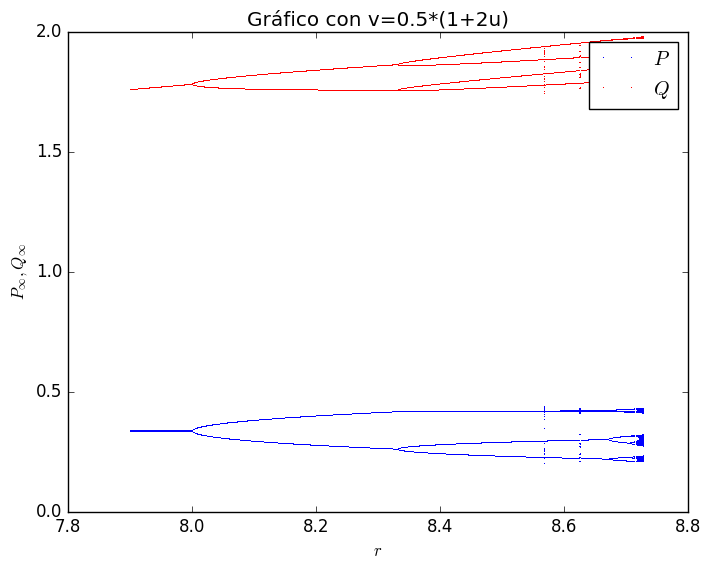

In [142]:
rrange3 = 7.9:2.0^-10:9.0
R3,P3,Q3=plot1(F3, p3, rrange3, 20000,500, "Gráfico con v=0.5*(1+2u)");

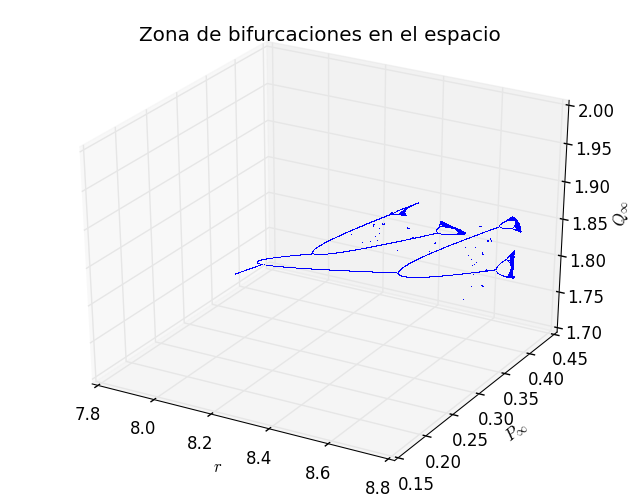

PyObject <matplotlib.text.Text object at 0x7feec0b5dd50>

In [143]:
plot3D(R3,P3,Q3,"b,")
xlabel(L"r")
ylabel(L"P_\infty")
zlabel(L"Q_\infty")
title("Zona de bifurcaciones en el espacio")

Se tiene un nuevo gráfico, con bifurcaciones de doblamiento de periódo torcidas.

In [144]:
r = 8.4
X0 =  p3(r)
plot2(F3, X0, r, 20000,500, "Diagrama de fase con r=$r y v=0.5(1+2u), para los primeros n=10000","b");

  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /home/mrg/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /home/mrg/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /home/mrg/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /home/mrg/.julia/v0.5/IJulia/src/kerne

LoadError: LoadError: UndefVarError: plot not defined
while loading In[144], in expression starting on line 3

Aunque el comportamiento es el mismo que el que ya se describió, en el otro caso de bifurcaciones de doblamiento de periodo.

Si graficamos un poco después:

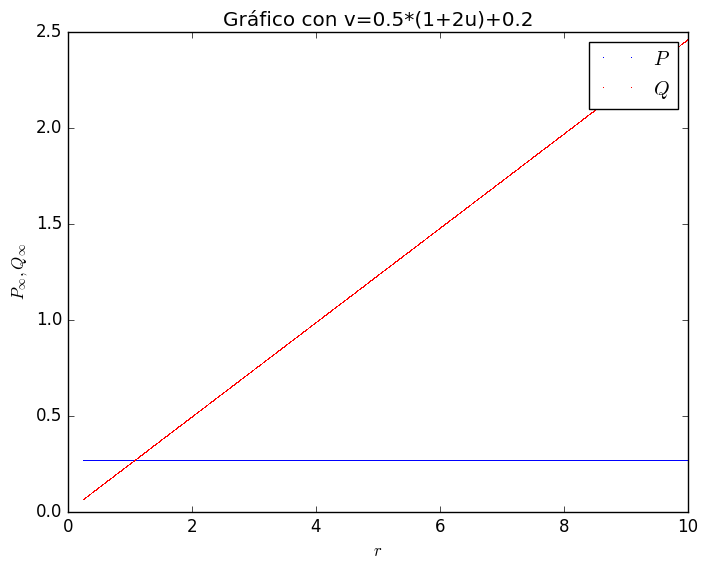

In [145]:
s,u,K = 3.0,0.25,1.0
v=0.5(1+2u)+0.2
p3(r)=pE2([r,s,u,v])-[0.0,0.06]
F3(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);
rrange3 = 0.0:2.0^-8:10.0
plot1(F3, p3, rrange3, 20000,500, "Gráfico con v=0.5*(1+2u)+0.2");

Ya no aparece la zona con doblamiento de periodo. 

Un poco antes, aparece una zona interesante:

In [146]:
s,u,K = 3.0,0.25,1.0
v=0.5(1+2u)-0.2
p3(r)=pE2([r,s,u,v])-[0.0,0.06]
F3(Xt,r)=CP_Simple(Xt,[r,s,u,v,K]);
rrange3 = 0.0:2.0^-8:10.0
plot1(F3, p3, rrange3, 20000,500, "Gráfico con v=0.5*(1+2u)-0.2");

pp3(r)=pE2([r,s,u,v])
Lyrrange3 = 0.0:2.0^-5:10.0
Lyapuplot(F3, pp3, Lyrrange3 , 0.2, 5000)
plot([0.0,6.0],[0.0,0.0])

LoadError: LoadError: UndefVarError: Lyapuplot not defined
while loading In[146], in expression starting on line 10

Se observa que el exponente de Lyapunov $\lambda>0$, entonces tenemos regiones caóticas.

## Conclusiones

A pesar de que el modelo que usamos es una de las versiones más simples del módelo de Depredador-Presa, el modelo tiene mucha dinámica y fenómenos interesantes.

Aparecen zonas con bifurcaciones de doblamiento de périodo, algunas de éstas pueden tener caos.

Por lo regular, este modelo converge a un punto, o bien a una órbita cerrada.

En resumen, se tiene que:

1. En $r<\frac{1}{2}(1+2u)$ se tienen regiones donde existen bifurcaciones de doblamiento de périodo y caos.
2. En $r>1+u$ es dónde inician las bifurcaciones de Neimark-Sacker, alrededor de $E_2=\left[\frac{u}{v} ,\frac{r}{s}\left(1-\frac{u}{ v} \right) \right]$.
3. Entre estas regiones $\frac{1}{2}(1+2u)<r<1+u$ El modelo presenta un comportamiento estable, con el punto $E_2$ fijo y atractivo.
4. El punto $E_0=[0,0]$ Es un punto silla, atractivo para los depredadores, repulsivo para las presas.
5. El punto $E_0=[1.0,0.0]$ Es un otro punto silla, para las presas pero repulsivo para los depredadores.

In [165]:
#Pkg.add("PyPlot");
#Pkg.add("Combinatorics");
#Pkg.add("StatsBase");
#Pkg.add("Gadfly")
#Pkg.add("Plots");
#Pkg.update();

# Todas las funciones grandes dentro de este programa tienen buenos docs. No los dejes solos...
using PyPlot, Gadfly, StatsBase, Combinatorics,Plots;

### Iniciando el campo de juego
Simulación de un mundo discreto de depredador - presa discreto

# Simulación

In [148]:
#0.1 Iniciar constantes y arreglos

const NGridSize = 12 :: Int        #Tamaño de Matriz
const TotalTurns = 100 :: Int #Turnos de tiempo global

const α = .5                       #Coeficiente de clon de presa

const β = .5                       #Coeficiente de clon de depredador
const ϵ_inicial = -3 :: Int               #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .1                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .333                   #Densidad de depredadores

#0.2 Construir matriz
const items = [-3,-2,-1,0,1]
const weights = [ρ_1 /3, ρ_1 /3, ρ_1 /3, 1-ρ_1-ρ_2, ρ_2]

# Chulada 1 con paquete StatsBase
Grid = reshape(sample(items,WeightVec(weights),NGridSize^2, replace=true)  ,NGridSize,NGridSize) ::Array{Int,2}

12×12 Array{Int64,2}:
 -1   0  -2   1   1   0  -1   0   1   1   0   1
  1  -3   1   0   1   0   0  -3  -2   0   0   1
  0   0   1   1   1   1  -3   1   1   0  -3  -1
 -1   1   1   1  -1  -2   1  -2   1   1   0   1
 -2  -2   1  -1   1  -1   1   0   0   1  -2   1
  0   1  -1  -1   0  -1   0  -1  -2   0  -2  -1
 -1   0   0   1  -2   0   1   0  -3  -1   1   1
  0  -1   1   0   1   1  -3   1   1   0  -3  -2
  1   1   0   1   1   0  -3   1   0   0  -1   1
 -1   1  -3  -1   0   0  -2  -3   1  -1   1   1
  1   1   0   1  -3  -2  -1   1  -3   0   1   1
  0   0  -3   0   0   1   1   1  -1   0   1  -2

### Reglas de comportamiento

A considerar:

Si es presa
1. Si se puede mover
2. Si se clona

Si es depredador
1. Si puede mover
2. Si come
3. Si se clona

Consideraciones "amables":
- Fronteras toroidales
- Vecinos a distancia 1
- ¿Si puede comer el lobo, come?
- ¿Quién juega primero?

In [149]:
"""
check_vecinos_vacios(Row::Int,Col::Int)

Esta función revisa si en un vecindario de las 8 casillas adyacentes a una entrada en la matriz de Grid
existe al menos un solo vecino vacío. El código toma en cuenta los casos donde la frontera es toroidal.
Ejemplo:
```julia
julia> a=eye[2,2]
julia> check_vecinos_vacios(1,1)
1
julia> check_vecinos_vacios(1,2)
0
"""
function check_vecinos_vacios(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int)
    YSouth = mod(Row,NGridSize)+1
    XWest = mod(Col,  NGridSize) +1
    XEast = mod(Col-2,  NGridSize) +1
    YNorth = mod(Row-2, NGridSize) +1
    
    if Grid[YNorth, Col]== 0 ||Grid[Row, XEast]==0 ||
    Grid[Row, XWest]==0 || Grid[YSouth, Col]==0 ||
    Grid[YNorth,XEast]==0 || Grid[YNorth,XWest]==0 ||
    Grid[YSouth,XEast]==0 || Grid[YSouth,XWest]== 0
        return 1
    
    else return 0
    end
end

"""
check_comer_depredador(Row::Int,Col::Int,Grid::Array{Int,2})

Esta función revisa si en un vecindario de las 8 casillas aledañas a la entrada (Row,Col) existe al menos
una presa, y regresa un 1 en dado caso, 0 c.o.c. El código toma en cuenta el caso donde la frontera es toroidal.
julia> a=eye[2,2]
julia> check_comer_depredador(1,1)
1
julia> b = zeros[2,2]
julia> check_comer_depredador[1,1]
0
"""
function check_comer_depredador(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int)
    
    if Grid[Row,Col] == 0 || Grid[Row,Col] == 1
        return 0
    end
    
    
    YSouth = mod(Row,NGridSize)+1
    XWest = mod(Col,  NGridSize) +1
    XEast = mod(Col-2,  NGridSize) +1
    YNorth = mod(Row-2, NGridSize) +1
    
    if Grid[YNorth, Col] > 0 || Grid[Row, XEast] > 0 || Grid[Row, XWest] > 0 ||  Grid[YSouth,Col] > 0 || Grid[YNorth,XEast] > 0 || Grid[YNorth,XWest] > 0 || Grid[YSouth,XEast] > 0 ||  Grid[YSouth,XWest] > 0
        return 1
    else return 0
    end
end

"""
check_mover_depredador(Row::Int,Col::Int,Grid::Array{Int,2})

Esta función revisa si en un vecindario de las 8 casillas aledañas a la entrada (Row,Col) existe al menos
un movimiento posible para el depredador, y regresa un 1 en dado caso, 0 c.o.c. El código toma en cuenta el caso donde la frontera es toroidal.
julia> a=eye[2,2]
julia> check_mover_depredador(1,1)
1
julia> b = zeros[2,2]
julia> check_comer_depredador[1,1]
0
"""
function check_mover_depredador(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int)
    YSouth = mod(Row,NGridSize)+1
    XWest = mod(Col,  NGridSize) +1
    XEast = mod(Col-2,  NGridSize) +1
    YNorth = mod(Row-2, NGridSize) +1
    
    if Grid[Row,Col] != 0 || Grid[YNorth, Col] >= 0 || Grid[Row, XEast] >= 0 || Grid[Row, XWest] >= 0 ||  Grid[YSouth,Col] >= 0 || Grid[YNorth,XEast] >= 0 || Grid[YNorth,XWest] >= 0 || Grid[YSouth,XEast] >= 0 || Grid[YSouth,XWest] >= 0
        return 1
    else return 0
        
    end
end

check_mover_depredador


### Consideraciones "amables":
- Fronteras toroidales 
    - yup
- Vecinos a distancia 1 
    - yup
- ¿Si puede comer el lobo, come?
    - yup
- ¿Quién juega primero?
    - presa
- ¿Energía de clon de depredador es independiente a si come?
    - yup
- ¿Tope de energía para depredador?
    - yup
- ¿Cuál es la distribución inicial de energía para los lobos?
    - Uniforme, desde la inicial

In [150]:
#Movimiento de presas

"""
moviendo_presa(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int,α::Float64)

Esta función establece el comportamiento de la presa.Si una
presa en (Row,Col) puede moverse a una casilla aledaña, lo haráy si
se clona con probabilidad α.

"""

function moviendo_presa(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int,α::Float64)
    #Sanity check
    if Grid[Row,Col] <= 0
        return 0 
    end
    
    if check_vecinos_vacios(Row,Col,Grid,NGridSize) == 1
        
        #Coeficiente de clonado - a veces deja una Dolly en su lugar...
        rand() < α ? clon = 1 : clon = 0
        
        #Chulada 2 - Fronteras toroidales en cuadrícula. 
        #Considerar usar la función mod1()
        #Con estas defs podemos revisar valores de vecinos.
        YSouth = mod(Row,NGridSize)+1
        XWest = mod(Col,  NGridSize) +1
        XEast = mod(Col-2,  NGridSize) +1
        YNorth = mod(Row-2, NGridSize) +1
        
        #Gran ciclo para intentar moverse a una casilla no ocupada.
        for i in 1:50
        
        #Oh...
        behave = rand(1:1:8)
            
        #Checando que nuestros vecinos sean movidas permitidas
        if behave == 1 && Grid[YNorth,XWest] == 0
            Grid[YNorth,XWest] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 2 && Grid[YNorth,Col] == 0
            Grid[YNorth,Col] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 3 && Grid[YNorth,XEast] == 0
            Grid[YNorth,XEast] = 1 
            Grid[Row,Col] = clon
                break
        elseif behave == 4 && Grid[Row,XWest] == 0
            Grid[Row,XWest] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 5 && Grid[Row,XEast] == 0
            Grid[Row,XEast] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 6 && Grid[YSouth,XWest] == 0
            Grid[YSouth,XWest] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 7 && Grid[YSouth,Col] == 0
            Grid[YSouth,Col] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 8 && Grid[YSouth,XEast] == 0
            Grid[YSouth,XEast] = clon
            Grid[Row,Col] = clon
                break
        
            end
        end
    end
end

            
"""
moviendo_depredador(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int,β::Float64)

Establece reglas de comportamiento para el depredador en (Row,Col). Si puede comer a una presa
aledaña, preferirá comer y moverse a sólo moverse. Se puede reproducir con
probabilidad β.
"""

#Movimiento de depredadores
function moviendo_depredador(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int,β::Float64)
    
    #Sanity check
    if Grid[Row,Col] >= 0
        return 0
    end
    
    puede_moverse = 0
    puede_comer = 0
    
    #Verificamos que se puedan mover
    puede_moverse = check_mover_depredador(Row,Col,Grid,NGridSize)
    puede_comer   = check_comer_depredador(Row,Col,Grid,NGridSize)
    
    prioridad = puede_moverse + puede_comer
        
    #Asignamos condicional a la ϵ_depredador si puede comer. Esta es la ϵ que se queda el
    # "original", per se. 
    if puede_comer == 1
        Grid[Row,Col] = ϵ_inicial
        else 
        Grid[Row,Col] = Grid[Row,Col] + Δϵ
    end
    
    #Starvation check
    if Grid[Row,Col] >= 0 
        return 0
    end
    
    ϵ_depredador = Grid[Row,Col]
    clon = 0::Int
    
    if check_mover_depredador(Row,Col,Grid,NGridSize) == 1
        
        #Coeficiente de clonado
        rand() < β ? clon = ϵ_inicial : clon = 0
        
        #Otra vez definimos a las casillas vecinas en fronteras toroidales
        YSouth = mod(Row,NGridSize)+1
        XEast = mod(Col,  NGridSize) +1
        XWest = mod(Col-2,  NGridSize) +1
        YNorth = mod(Row-2, NGridSize) +1
                
        #Con puro colmillo no ponemos un while por si las dudas...
        for i in 1:50
        
        behave = rand(1:1:8)
            
            # Chulada 3 - La segunda condicional impera que si puede comer y moverse, debe comer cuando se mueve.
            # ¿Ves cómo?
            if behave == 1 && Grid[YNorth,XWest] == puede_comer
                    Grid[YNorth,XWest] = ϵ_depredador
                    Grid[Row,Col] = clon    
                    break
                elseif behave == 2 && Grid[YNorth,Col] == puede_comer
                    Grid[YNorth,Col] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 3 && Grid[YNorth,XEast] == puede_comer
                    Grid[YNorth,XEast] = ϵ_depredador 
                    Grid[Row,Col] = clon
                    break
                elseif behave == 4 && Grid[Row,XWest] == puede_comer
                    Grid[Row,XWest] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 5 && Grid[Row,XEast] == puede_comer
                    Grid[Row,XEast] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 6 && Grid[YSouth,XWest] == puede_comer
                    Grid[YSouth,XWest] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 7 && Grid[YSouth,Col] == puede_comer
                    Grid[YSouth,Col] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 8 && Grid[YSouth,XEast] == puede_comer
                    Grid[YSouth,XEast] = ϵ_depredador 
                    Grid[Row,Col] = clon
                    break
            
            end
        end
    end
end

 

moviendo_depredador

### ¿Pifa?

In [151]:
NGridSize = 5;Grid = eye(Int,5,5); Grid[2,2] = -3; Grid

5×5 Array{Int64,2}:
 1   0  0  0  0
 0  -3  0  0  0
 0   0  1  0  0
 0   0  0  1  0
 0   0  0  0  1

In [152]:
moviendo_presa(4,4,Grid,NGridSize,.9)
Grid

5×5 Array{Int64,2}:
 1   0  0  0  0
 0  -3  0  0  0
 0   0  1  0  0
 0   0  0  1  0
 0   0  0  1  1

In [153]:
ϵ_inicial = -3
Δϵ = 1

moviendo_depredador(2,2,Grid,NGridSize, 0.)
Grid

5×5 Array{Int64,2}:
 -3  0  0  0  0
  0  0  0  0  0
  0  0  1  0  0
  0  0  0  1  0
  0  0  0  1  1

### The Big Loop!

In [154]:
#Super Gran Loop

"""
BigLoop(NGridSize::Int64, α::Float64, β::Float64, ϵ_inicial::Int64, Δϵ::Int64, γ::Float64, ρ_1::Float64, ρ_2::Float64, TurnTimer::Int64)

Esta función toma una familia de parámetros para simular un microcosmos de depredadores y presas en una matriz con
fronteras toroidales. Regresa los arreglos Presas, Depredadores, Turnos, Grid para poder graficarlos.
Primero define sus arreglos y coordenadas, empieza contadores, y luego en un gran loop de iteración evoluciona
los agentes de cambio con mover_depredador() y mover_presa(), para despues contar a los sobrevivientes y push! a arreglos.

"""
function BigLoop(
    
    NGridSize::Int,
    α::Float64,
    β::Float64,
    ϵ_inicial :: Int,
    Δϵ :: Int,
    γ :: Float64,
    ρ_1 :: Float64,
    ρ_2 :: Float64, 
    TurnTimer::Int,)
    #######################
    
    #Iniciar Matriz
    Espacio_Coordenadas = [(x,y) for x=1:NGridSize, y=1:NGridSize]
    items_0 = [-3,-2,-1,0,1]
    weights_0 = [ρ_1 /3, ρ_1 /3, ρ_1 /3, 1-ρ_1-ρ_2, ρ_2]
    Grid = reshape(sample(items_0,WeightVec(weights_0),NGridSize^2, replace=true),NGridSize,NGridSize) ::Array{Int,2}
    
    # Iniciar contadores y randomseed (para que sea replicable los resultados)
    srand(1234)
    iter=enumerate(Grid)
    Presas = [0]
    Depredadores = [0]
    Turnos = [0]
    
    #Chulada 4 del paquete de Combinatorics
    presas_vivas = count(iter->(iter>0), Grid)
    depredadores_vivos = count(iter->(iter<0), Grid)
    
    #Listos para pushear y graficar...
    push!(Presas,presas_vivas)
    push!(Depredadores, depredadores_vivos)
    
    #Variable auxiliar para recorrer sampleo
    tope = convert(Int,round(γ*NGridSize^2))   
    turn_counter = 0
    #The Big Loop-de-Loop!
    
    
    @inbounds for time_step in 1:TurnTimer


        #Ojo, esto se alenta en matrices esparsas...por...?
        aux = sample(Espacio_Coordenadas,tope;replace=false) :: Array{Tuple{Int64,Int64},1}
       
        #Chulada 5 con reinterpret y vector - Como convertir tuplas en arreglos
        sampleo = vec(reinterpret(Int, aux, (1,tope*2)))
        turn_counter += 1
        
        @inbounds for i in 1:tope*2-1

            Row,Col = sampleo[i], sampleo[i+1]

            # Who moves first? :D
            # Si las entradas no son una casilla vacía, entonces la registramos en todos nuestros
            # Arreglos, si no, simplemente se lo salta
            if Grid[Row,Col] != 0 
                #Movemos a las presas o depredadores
                moviendo_presa(Row,Col,Grid,NGridSize,α)
                moviendo_depredador(Row,Col,Grid,NGridSize,β)

            end
        end
                #Contamos a los vivos                
                presas_vivas = count(iter->(iter>0), Grid)
                depredadores_vivos = count(iter->(iter<0), Grid)
                #Guardamos cuantos vivos hay
                push!(Presas,presas_vivas)
                push!(Depredadores, depredadores_vivos)
                #Guardamos el turno
                push!(Turnos, turn_counter)
    end
    
    print("\n Simulation complete! \n!")
    return Presas,Depredadores,Turnos, Grid
    
end
    
    
    

BigLoop

### Simulando...



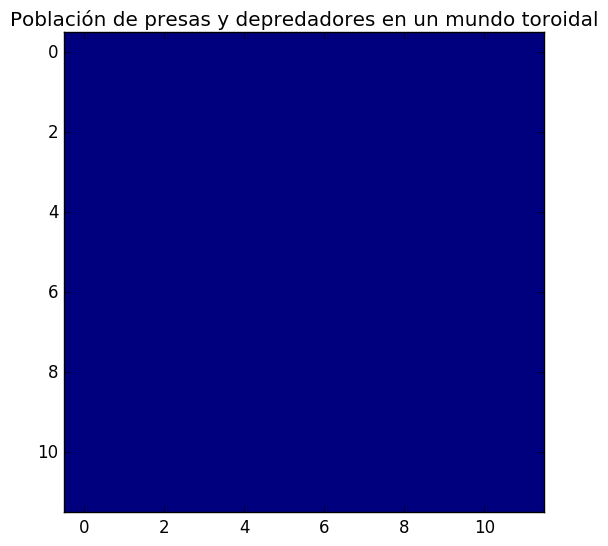


 Simulation complete! 
!

PyObject <matplotlib.text.Text object at 0x7feea4d6fdd0>

In [155]:
const NGridSize = 12 :: Int        #Tamaño de Matriz
const TurnTimer = 100 :: Int       #Turnos de tiempo global

const α = .7                       #Coeficiente de clon de presa

const β = .3                       #Coeficiente de clon de depredador
const ϵ_inicial = -3::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .333                   #Densidad de depredadores

#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################

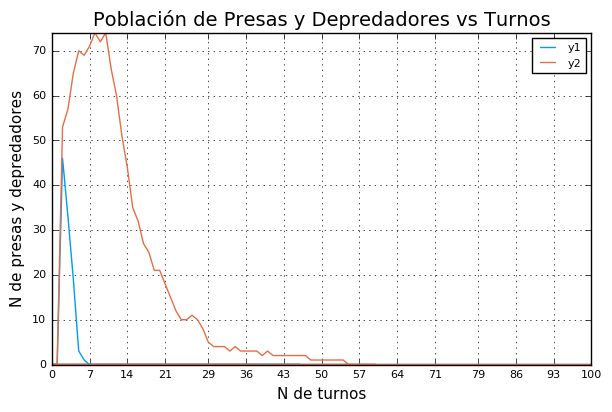

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif")

In [156]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

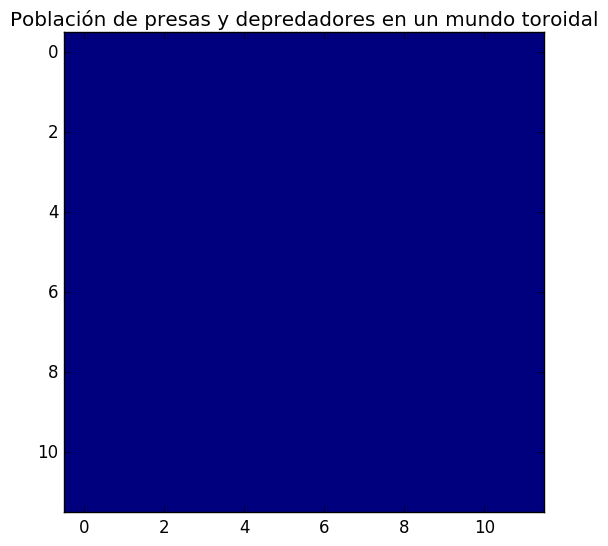


 Simulation complete! 
!

PyObject <matplotlib.text.Text object at 0x7fee94e804d0>

In [157]:
const NGridSize = 12 :: Int        #Tamaño de Matriz
const TurnTimer = 100 :: Int       #Turnos de tiempo global

const α = .8                       #Coeficiente de clon de presa

const β = .05                       #Coeficiente de clon de depredador
const ϵ_inicial = -3::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .333                   #Densidad de depredadores
#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################

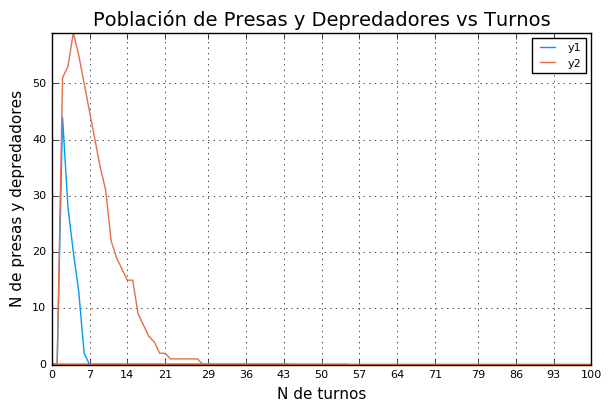

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif")

In [158]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

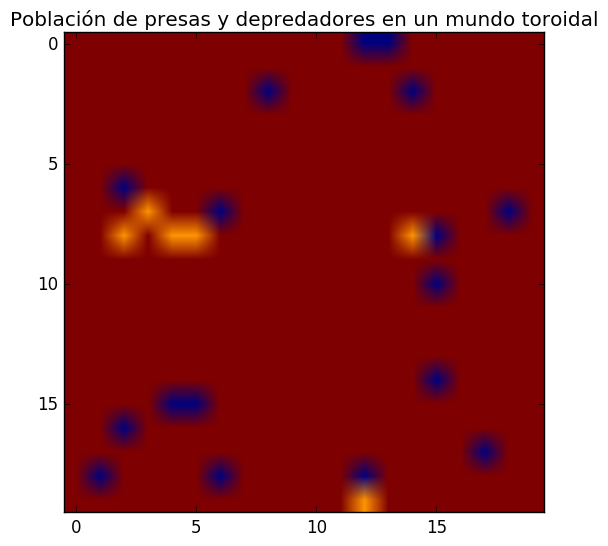


 Simulation complete! 
!

PyObject <matplotlib.text.Text object at 0x7fee95231c90>

In [166]:
const NGridSize = 20 :: Int        #Tamaño de Matriz
const TurnTimer = 100 :: Int       #Turnos de tiempo global

const α = .9                       #Coeficiente de clon de presa

const β = .0123                      #Coeficiente de clon de depredador
const ϵ_inicial = -2::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .1                     #Densidad de depredadores
#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################

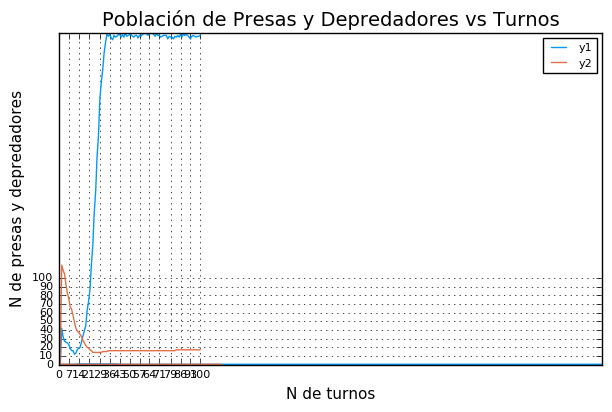

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif")

In [167]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

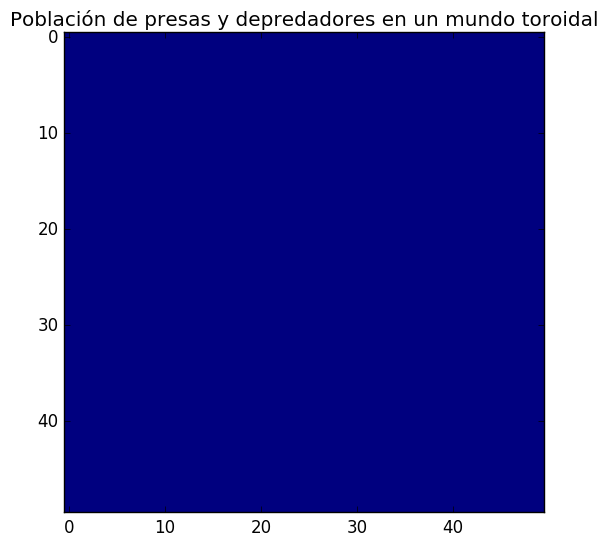


 Simulation complete! 
!

PyObject <matplotlib.text.Text object at 0x7feec1194b50>

In [161]:
const NGridSize = 50 :: Int        #Tamaño de Matriz
const TurnTimer = 300 :: Int       #Turnos de tiempo global

const α = .6                       #Coeficiente de clon de presa

const β = .02                       #Coeficiente de clon de depredador
const ϵ_inicial = -5::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .2                   #Densidad de depredadores
#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################

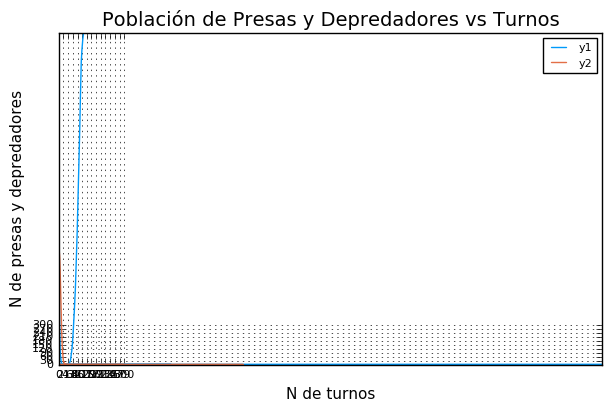

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif")

In [162]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

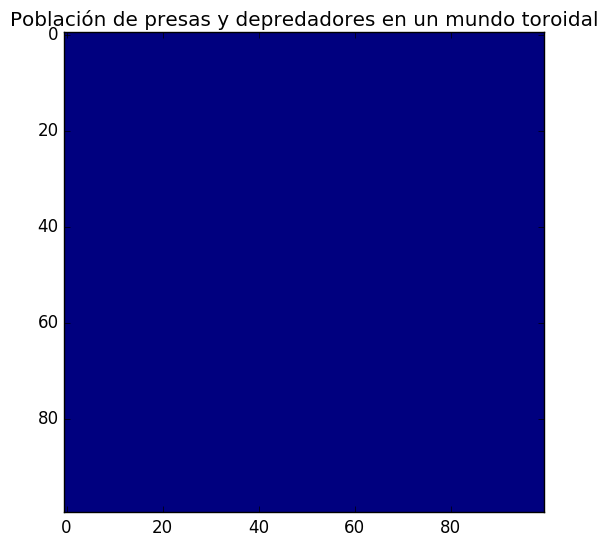


 Simulation complete! 
!

PyObject <matplotlib.text.Text object at 0x7fee9518f9d0>

In [163]:
const NGridSize = 100 :: Int        #Tamaño de Matriz
const TurnTimer = 100 :: Int       #Turnos de tiempo global

const α = .55                       #Coeficiente de clon de presa

const β = .025                       #Coeficiente de clon de depredador
const ϵ_inicial = -3::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .8                     #Densidad de presas
const ρ_2 = .1                   #Densidad de depredadores
#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################

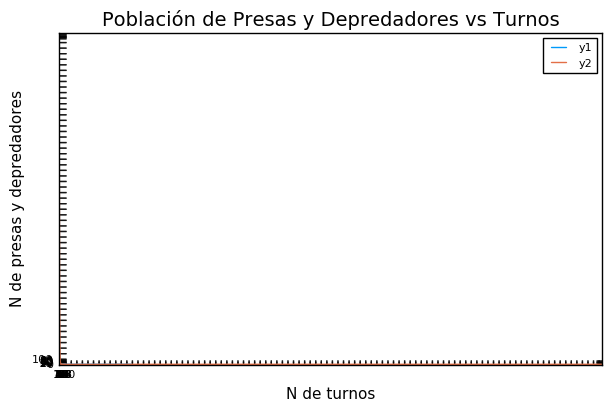

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/proys/RazCaroRodolfo/tmp.gif")

In [164]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

### Bibliografía
 Wilenskz, Reisman,2006. "Thinking Like a Wolf, a Sheep, or a Firefly:Learning Biology Through Constructing and Testing Computational Theories--an Embodied Modeling Approach", http://ccl.northwestern.edu/papers/wolfsheep.pdf